## EOSC 556B - Assignment 3
Name: Parth Pokar
Student Number: 43949999

# 2D cross-well tomography
The forward simulation takes the form

$$
t_j = \int_{\Gamma_j} s(x, y) dl
$$


where $s(x,y) = 1/v(x, y)$ is the slowness (equal to the inverse of the velocity). Note that we will work with $x$ as the first dimension and $y$ as the second dimension.

Set-up

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import discretize

from SimPEG import seismic

from SimPEG import (
    maps,
    utils,
    survey,
    data,
    data_misfit,
    directives,
    optimization,
    regularization,
    inverse_problem,
    inversion,
)


In [2]:
## Define mesh
extent_x = 200
extent_y = 400

dx = 10
dy = 10

nx = int(np.ceil(extent_x / dx))
ny = int(np.ceil(extent_y / dy))

hx = np.ones(nx) * dx
hy = np.ones(ny) * dy
mesh = discretize.TensorMesh([hx, hy])

In [3]:
# Define survey
n_src = 10
y_src = np.linspace(dy/2, extent_y-dy/2, n_src)

source_locations = np.c_[np.zeros_like(y_src), y_src]
receiver_locations = np.c_[np.zeros_like(y_src) + mesh.nodes_x[-1], y_src]

rx = survey.BaseRx(receiver_locations)

source_list = []

for i in range(y_src.size):
    source_list.append(
        survey.BaseSrc(
            location=source_locations[i, :], receiver_list=[rx]
        )
    )
tomo_survey = seismic.straight_ray_tomography.Survey(source_list)


In [4]:
## build model
v0 = 1000
v1 = 2500
block_x = np.r_[60, 140]
block_y = np.r_[180, 220]

velocity_model = v0*np.ones(mesh.n_cells)
background_velocity = velocity_model.copy()

In [5]:
def add_block(velocity_model, block_x, block_y, value): 
    inds_block = (
        (mesh.cell_centers[:, 0] > block_x.min()) &
        (mesh.cell_centers[:, 0] < block_x.max()) &
        (mesh.cell_centers[:, 1] > block_y.min()) &
        (mesh.cell_centers[:, 1] < block_y.max()) 
    ) 

    velocity_model[inds_block] = value
    
    return velocity_model
    
velocity_model = add_block(velocity_model, block_x, block_y, v1) 

true_slowness_model = 1/velocity_model
background_slowness_model = 1/background_velocity

<Axes: title={'center': 'True model'}, xlabel='x', ylabel='y'>

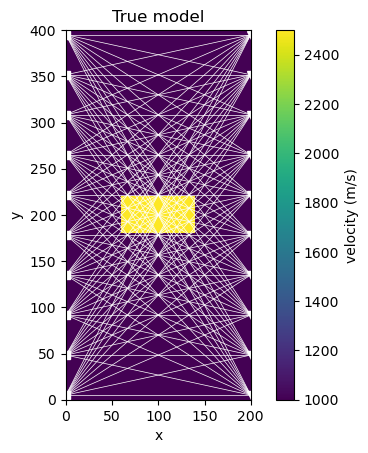

In [6]:
#plot model
def plot_model_survey(
    mesh, model, source_locations, receiver_locations, ax=None, 
    show_raypaths=True, vmin=None, vmax=None,title=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    
    cb = plt.colorbar(
        mesh.plot_image(model, ax=ax, pcolor_opts={"vmin":vmin, "vmax":vmax})[0], 
        ax=ax
    )
    
    cb.set_label("velocity (m/s)")
    
    ax.set_aspect(1)

    ax.plot(source_locations[:, 0], source_locations[:, 1], "ws", ms=6)
    ax.plot(receiver_locations[:, 0], receiver_locations[:, 1], "wv", ms=6)
    if title is None:
        ax.set_title("True model")
    else:
        ax.set_title(title)
    if show_raypaths is True: 
        for i in range(source_locations.shape[0]):
            for j in range(receiver_locations.shape[0]):
                ax.plot(
                    np.r_[source_locations[i, 0], receiver_locations[j, 0]],
                    np.r_[source_locations[i, 1], receiver_locations[j, 1]],
                    color="w",
                    linewidth=0.5
                )
    return ax

def plot_outline(ax, x=block_x, y=block_y):
    ax.plot([x.min(), x.min()], [y.min(), y.max()],"w--")
    ax.plot([x.max(), x.max()], [y.min(), y.max()], "w--")
    ax.plot([x.min(), x.max()], [y.min(), y.min()], "w--")
    ax.plot([x.min(), x.max()], [y.max(), y.max()], "w--")
    return ax


plot_model_survey(
    mesh, velocity_model, source_locations, receiver_locations,
    show_raypaths=True
)

In [7]:
## simulate data
simulation = seismic.straight_ray_tomography.Simulation(
    mesh=mesh,
    survey=tomo_survey,
    slownessMap=maps.IdentityMap(mesh),
)

In [8]:
#Predit data
background_data = simulation.dpred(background_slowness_model)
clean_data = simulation.dpred(true_slowness_model)

# Q1a
Add a block near the center of the survey region with a different velocity. The velocity can be smaller or larger (use a difference of at least a factor of 2). Plot the true model, the simulated data in a homogeneous backgroud, the data with the block and the difference between the data with and without the block. Don't add any noise yet.

In [9]:
levels = np.linspace(0.10, 0.50, 21)
contours = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

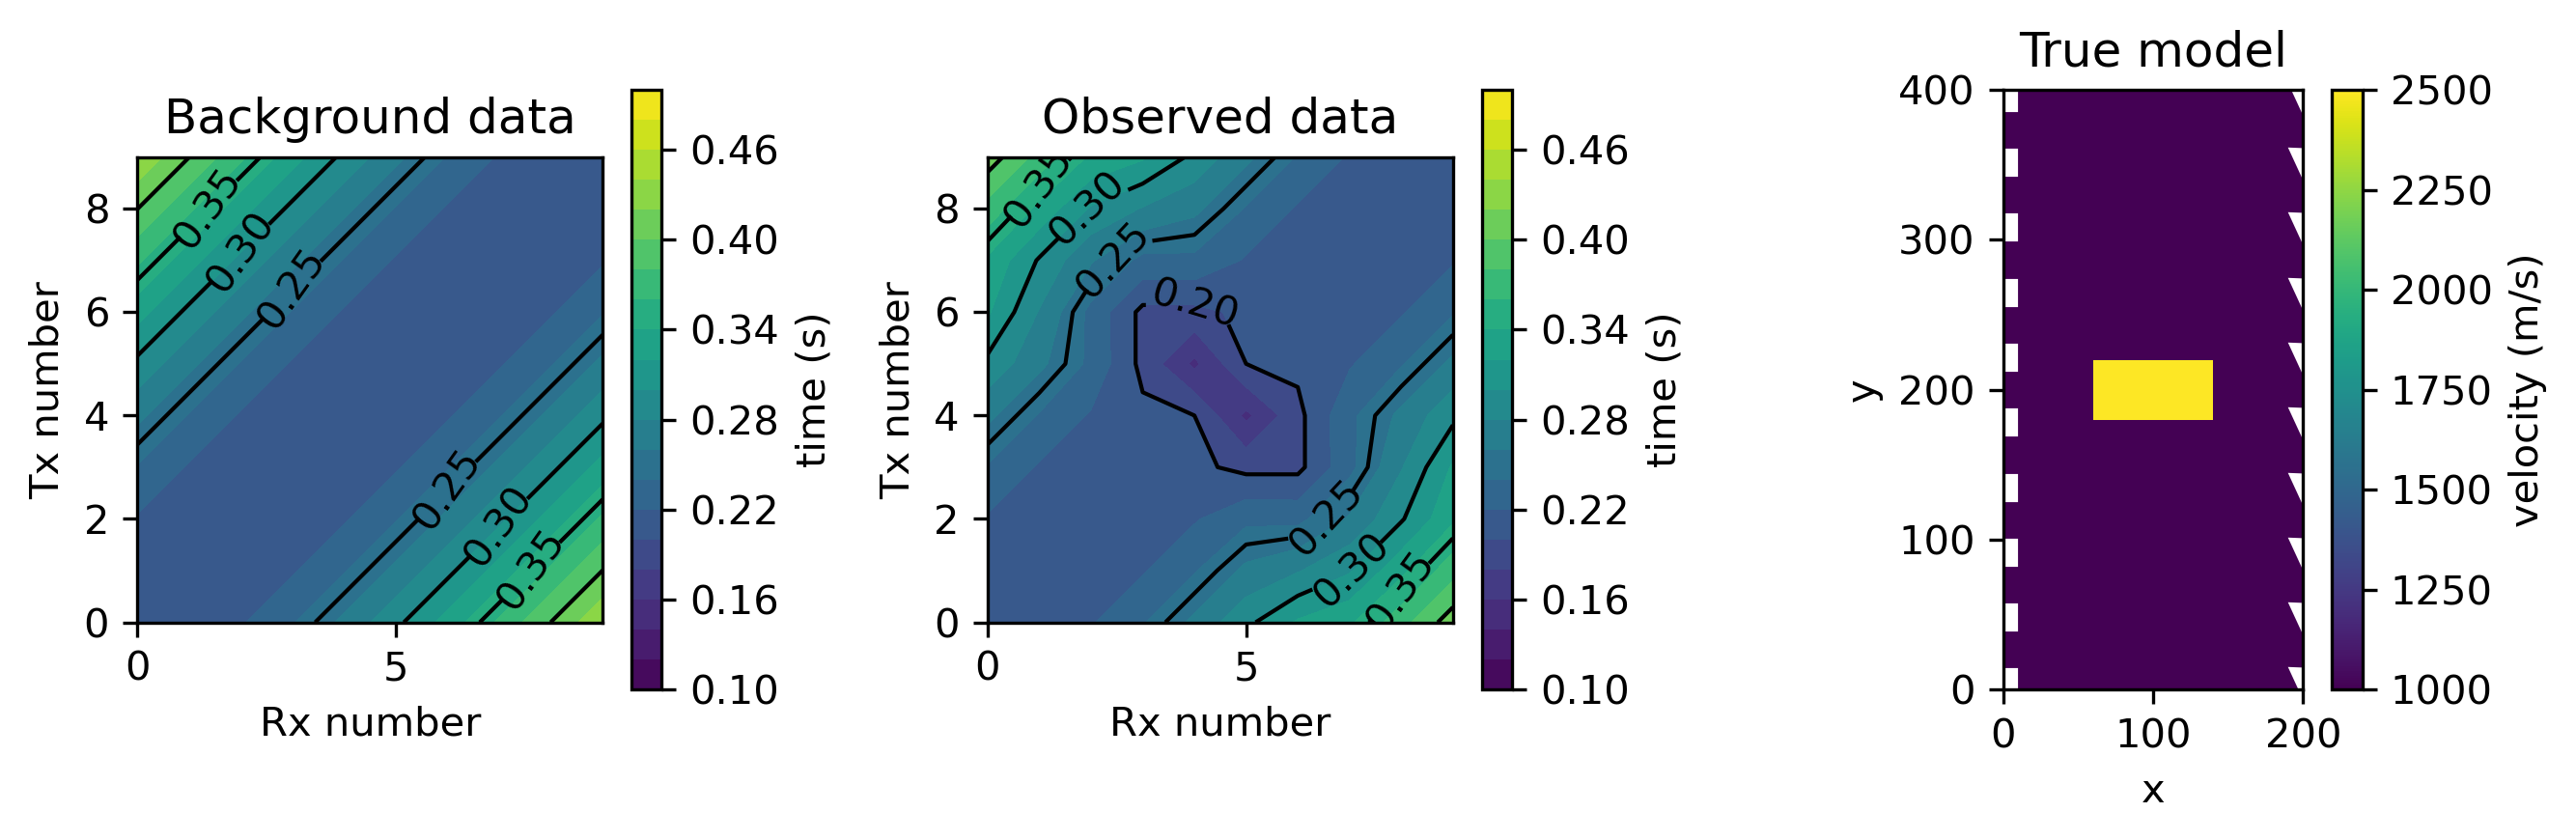

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
plot_model_survey(
    mesh, velocity_model, source_locations, receiver_locations,
    show_raypaths=False, ax = ax[2]
)

def plot_data(ax, dplot, title,contour=True,vmin=None,vmax=None):
    if contour is True:
        cb = plt.colorbar(ax.contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels,vmin=vmin,vmax=vmax))
        CS = ax.contour(
                dplot.reshape(n_src, n_src, order="F"),
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax.clabel(CS, inline=True, fontsize=10)

    else:
        cb = plt.colorbar(ax.contourf(dplot.reshape(n_src, n_src, order="F"),vmin=vmin,vmax=vmax))
    ax.set_aspect(1)
    ax.set_xlabel("Rx number")
    ax.set_ylabel("Tx number")
    cb.set_label("time (s)")
    ax.set_title(title)

for i, dplot in enumerate([background_data, clean_data]):
    plot_data(ax[i], dplot, ["Background data", "Observed data"][i])
plt.tight_layout()

    # Q1b.
First, lets convince ourselves that the forward simulation is working properly. By looking at the data for the uniform 1000 m/s background, can you demonstrate that the forward simulation is working properly? You might want to test a couple of different uniform backgrounds to convince yourself.

Ans
Given a background velocity of 1000 m/s we expect the straight-ray traveltime to be 0.2s. Similarly, for background velocity of 2000 m/s and 500 m/s we expect the traveltime to be 0.1s and 0.4s respectively. We can test this by simulating the data for these three background velocities and plotting the data as shown below.

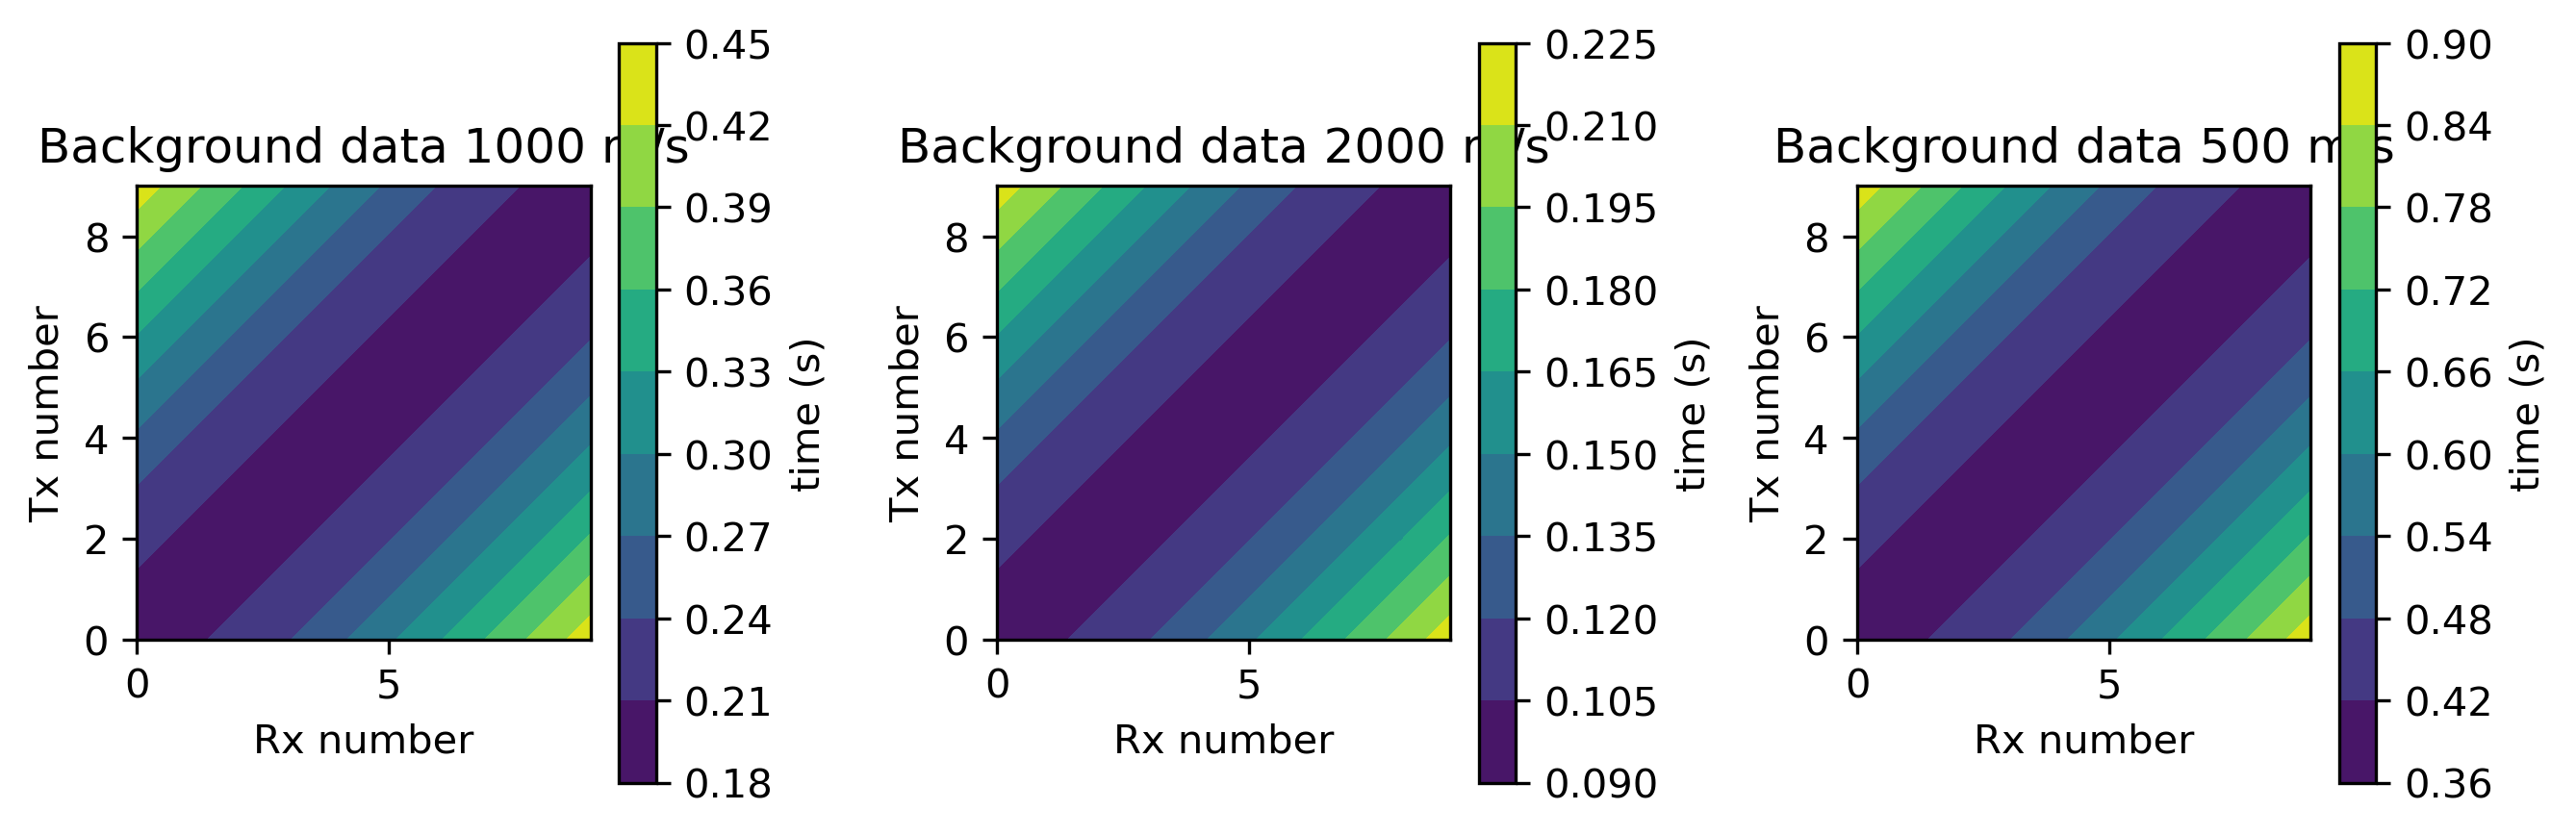

In [11]:
background_velocity_test = [1000,2000,500]
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
for i in range(3):
    background_data_test = simulation.dpred(1/background_velocity_test[i]*np.ones(mesh.n_cells))
    plot_data(ax[i], background_data_test, f"Background data {background_velocity_test[i]} m/s",contour=False)
plt.tight_layout()

# Q1.c
What is the maximum difference between the model with and without the block? What is that difference as a percentage?

Max difference: 4.91e-02 s
Max difference percent: 11.94%


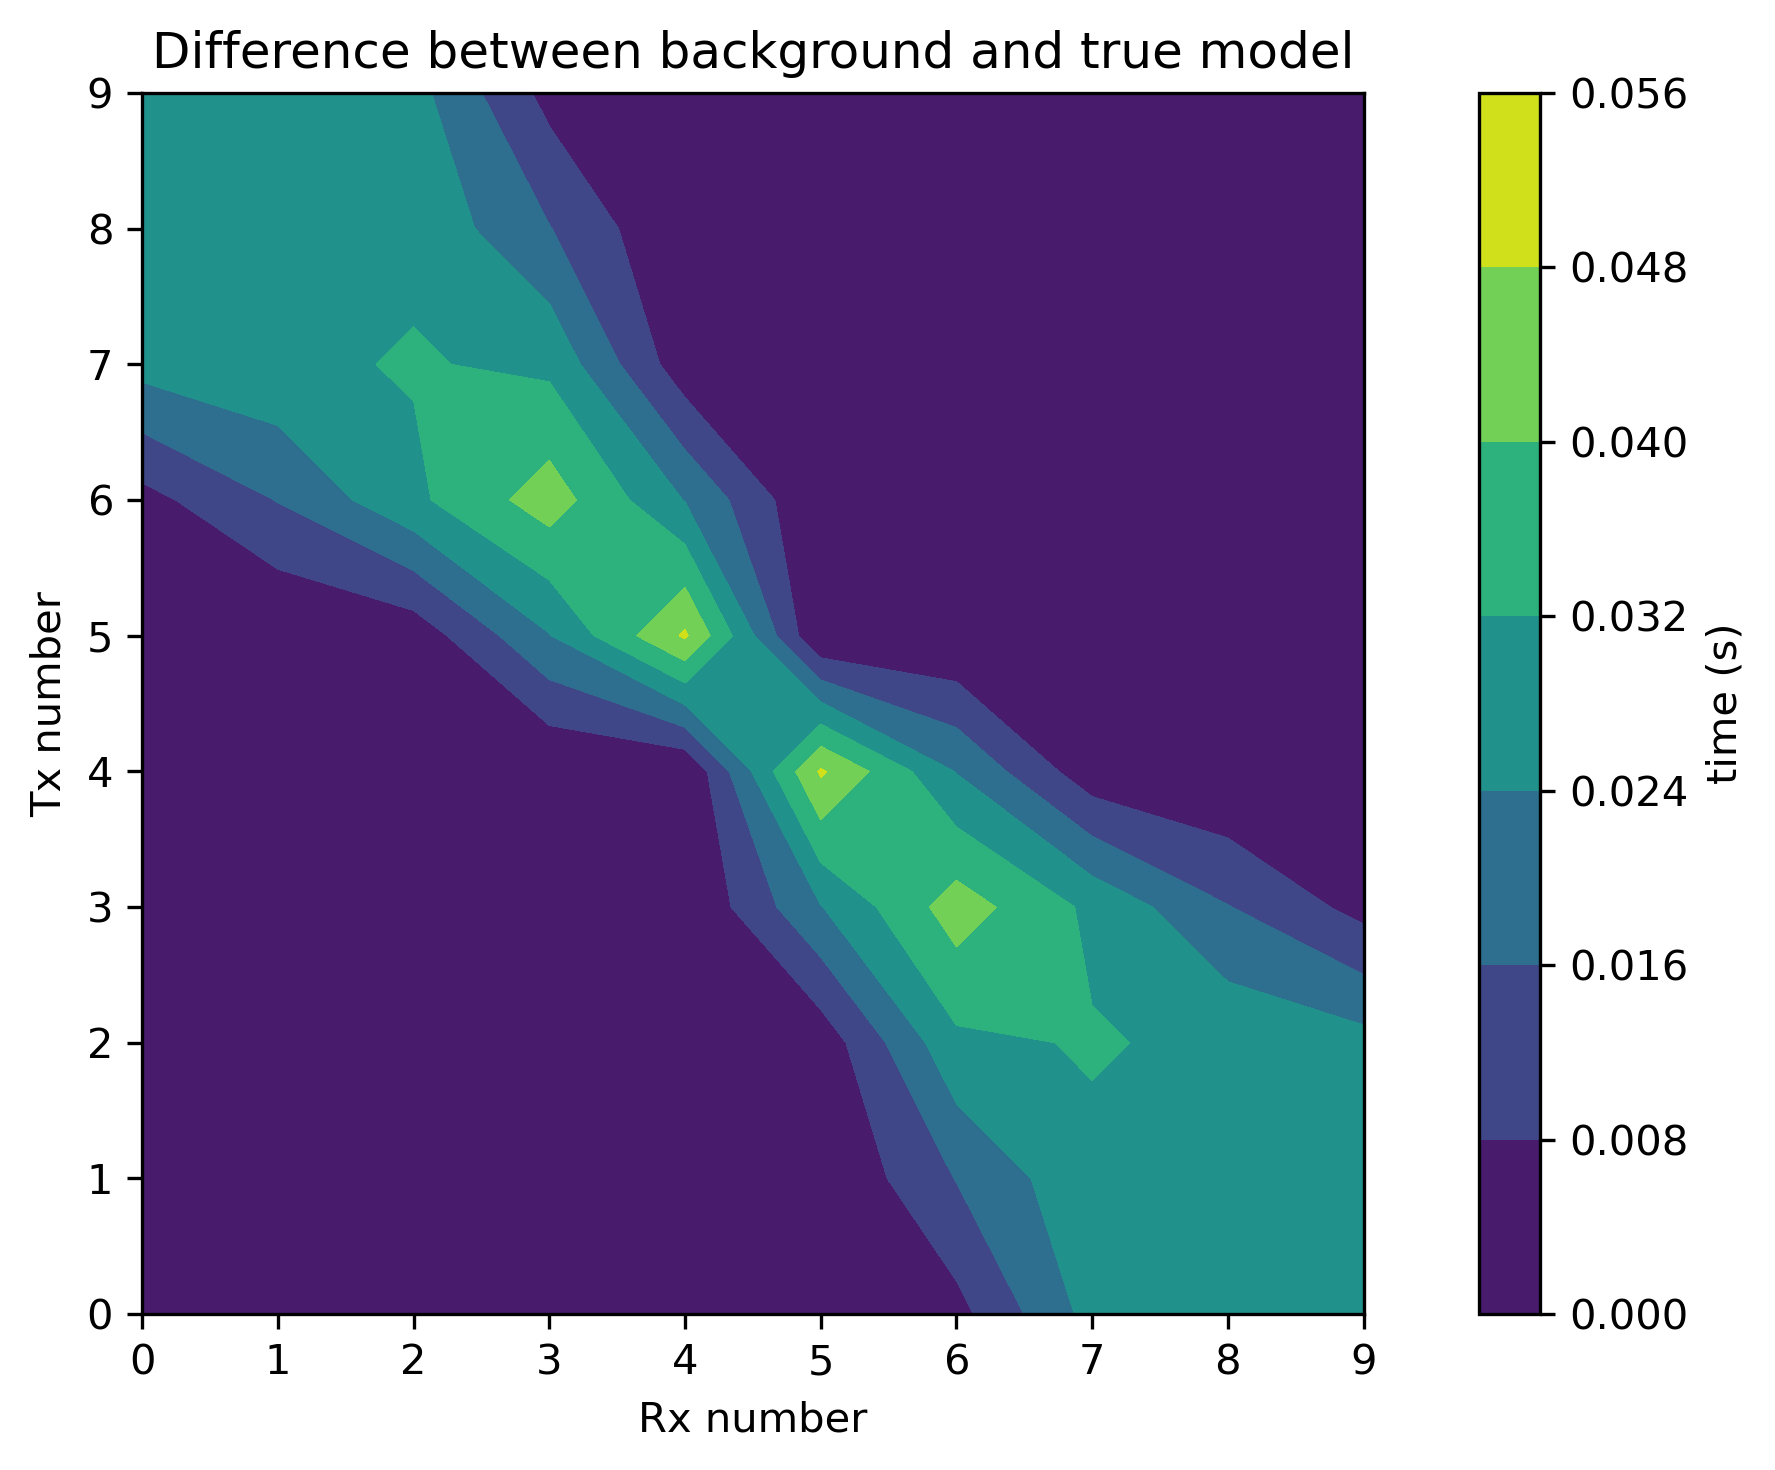

In [12]:
max_diff = np.max(np.abs(background_data - clean_data))
max_diff_percent = max_diff/np.max(clean_data)*100
print(f"Max difference: {max_diff:.2e} s\nMax difference percent: {max_diff_percent:.2f}%")
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)
plot_data(ax, np.abs(clean_data - background_data), "Difference between background and true model",contour=False)
plt.tight_layout()

# Q1.d
Now we will examine detectability of a target. Let's explore what happens when you add noise. Generate plots for a couple of choices of noise levels, where the noise is added as a percentage (e.g. `np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)`, where percentage error is `100% * relative_error`). At what noise level do you no longer have confidence that you can see the target?

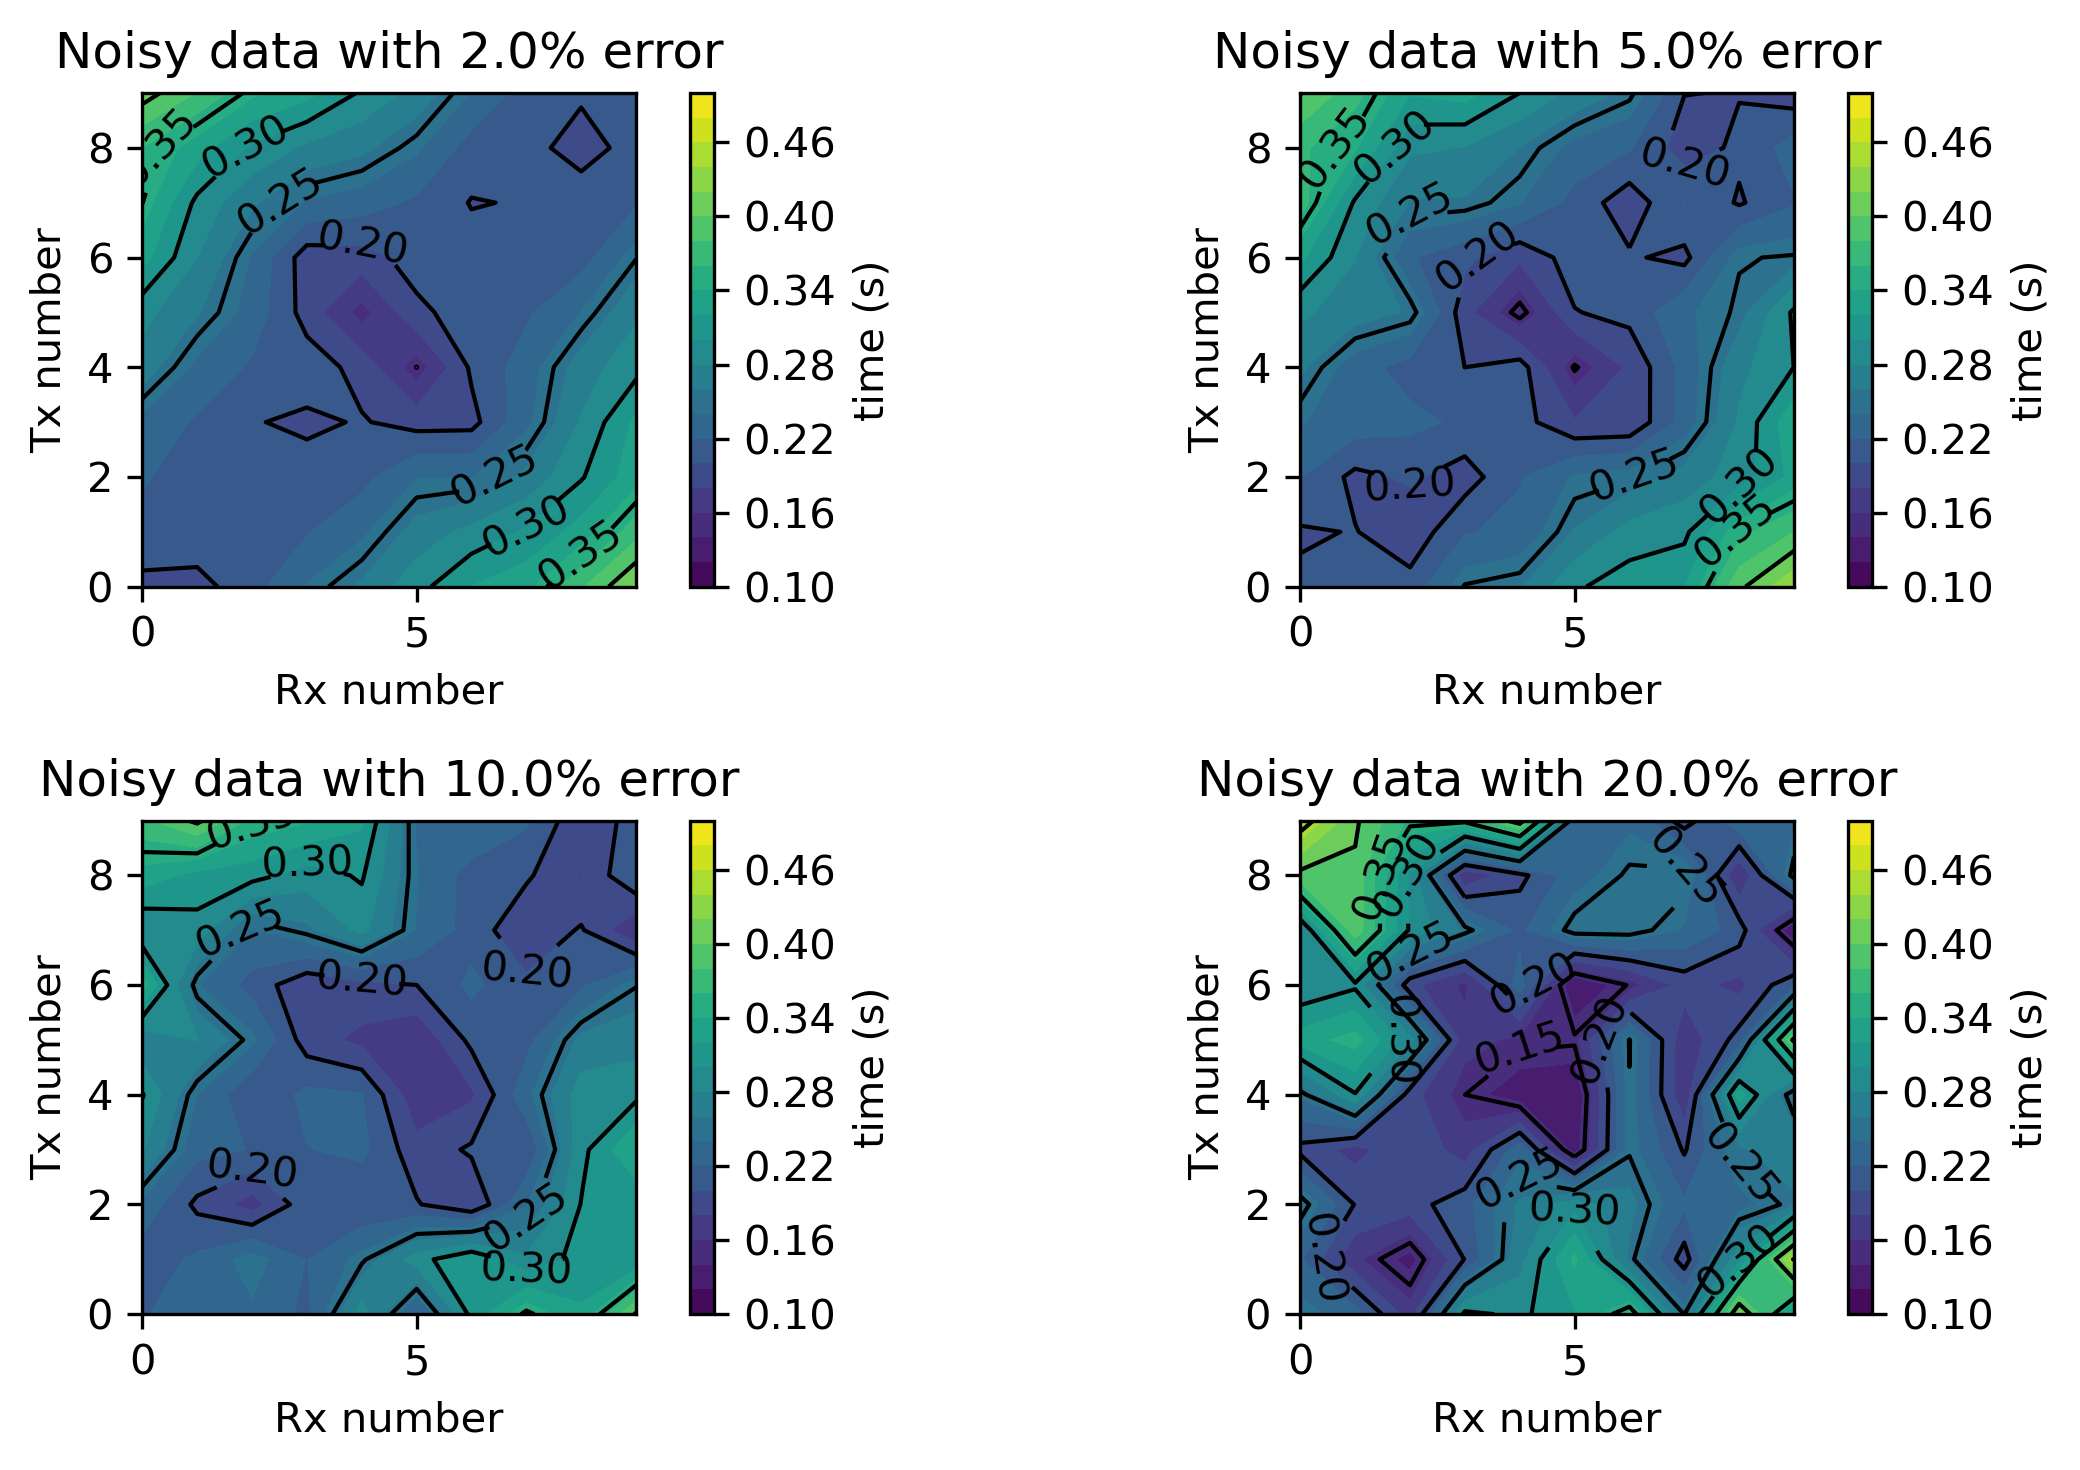

In [13]:
relative_error = [0.02,0.05,0.1,0.2]
fig, ax = plt.subplots(2, 2, figsize=(8, 5), dpi=300)
for i in range(4):
    noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error[i] * np.abs(clean_data)
    plot_data(ax.flatten()[i], noisy_data, f"Noisy data with {relative_error[i]*100}% error",contour=True)
plt.tight_layout()


# Q1.e
Next, we will move the target. Move it so that it is centered within the top 100m of the survey area and again plot the data with and without the block. At what noise levels would you now expect would be the maximum at which we could expect to see the target? Is this similar or different that if the block is in the center? Why?

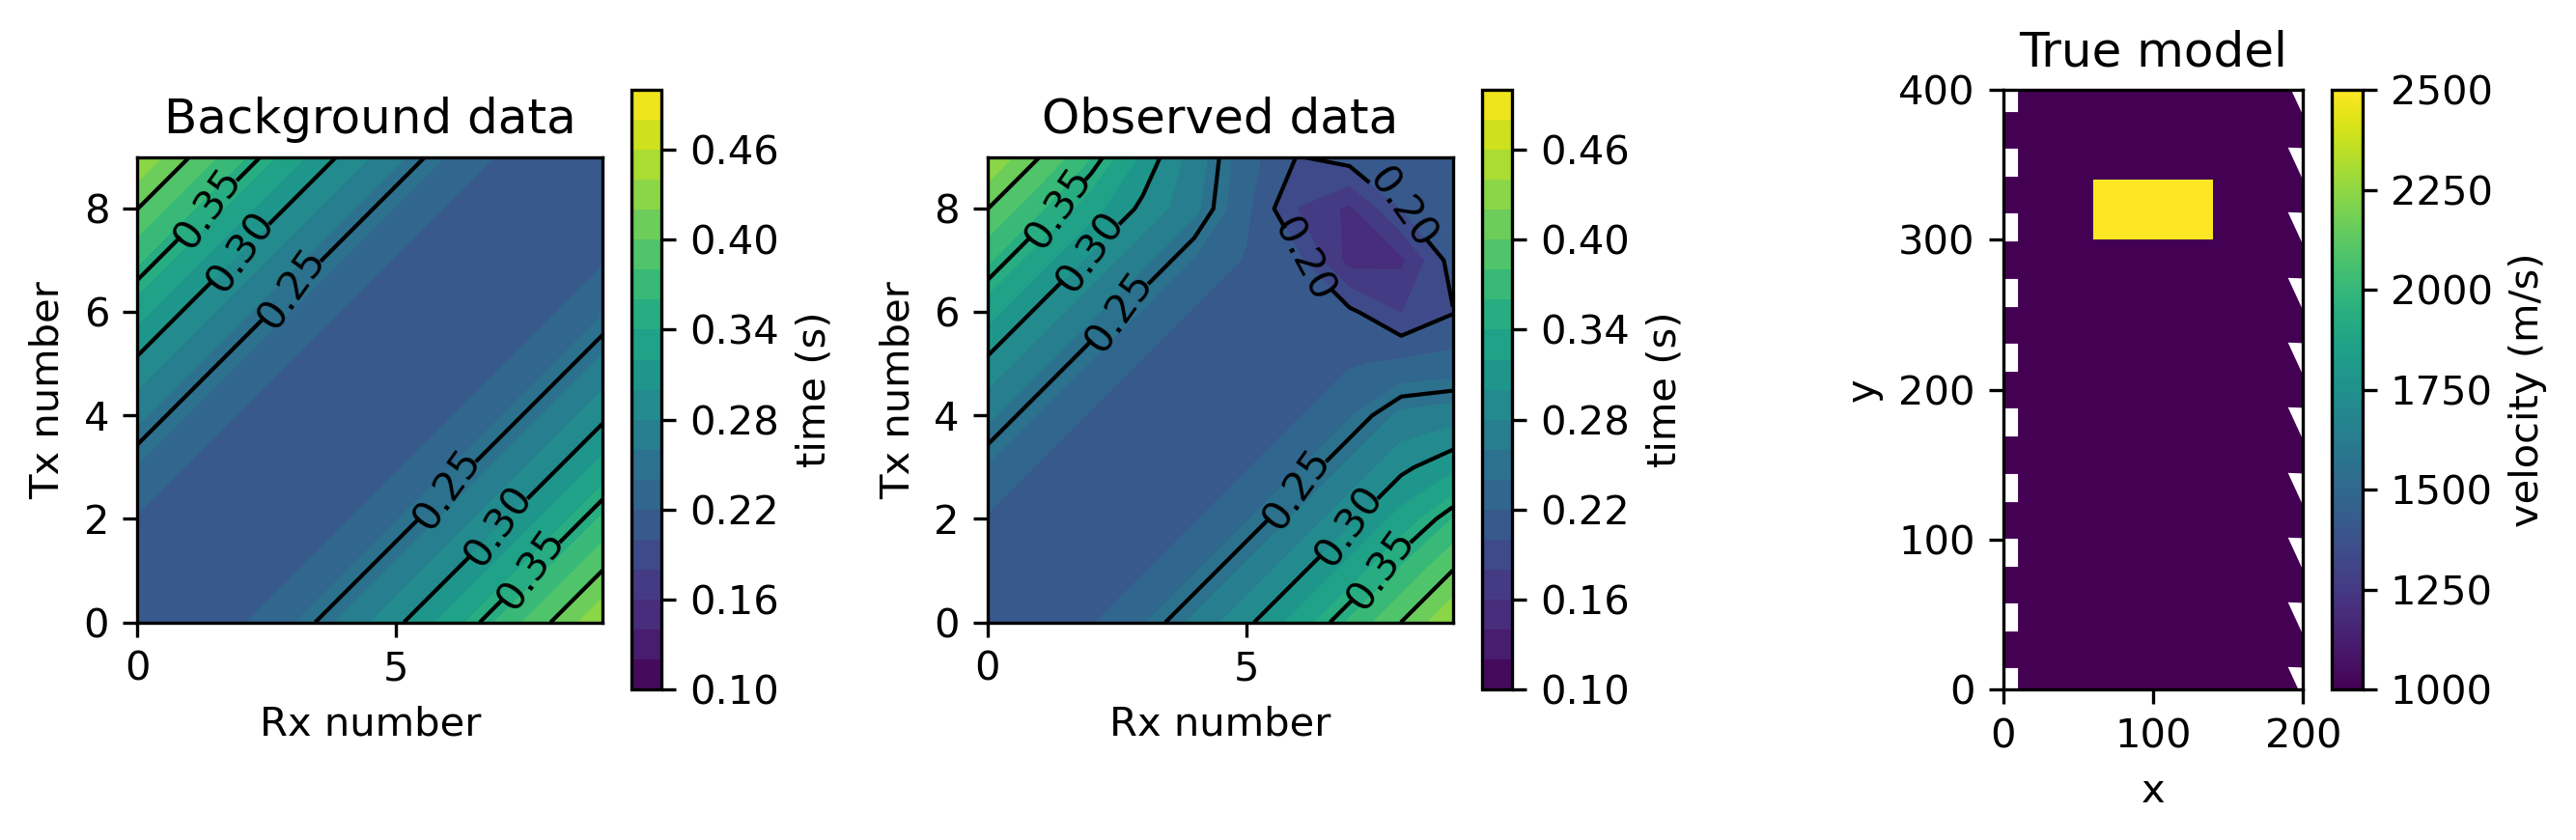

In [14]:
shifted_block_y = np.r_[300, 340]
shifted_velocity_model = v0*np.ones(mesh.n_cells)
shifted_velocity_model = add_block(shifted_velocity_model, block_x, shifted_block_y, v1)
shifted_slowness_model = 1/shifted_velocity_model

shifted_clean_data = simulation.dpred(shifted_slowness_model)
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
plot_model_survey(
    mesh, shifted_velocity_model, source_locations, receiver_locations,
    show_raypaths=False, ax = ax[2]
)
for i, dplot in enumerate([background_data, shifted_clean_data]):
    plot_data(ax[i], dplot, ["Background data", "Observed data"][i])
plt.tight_layout()


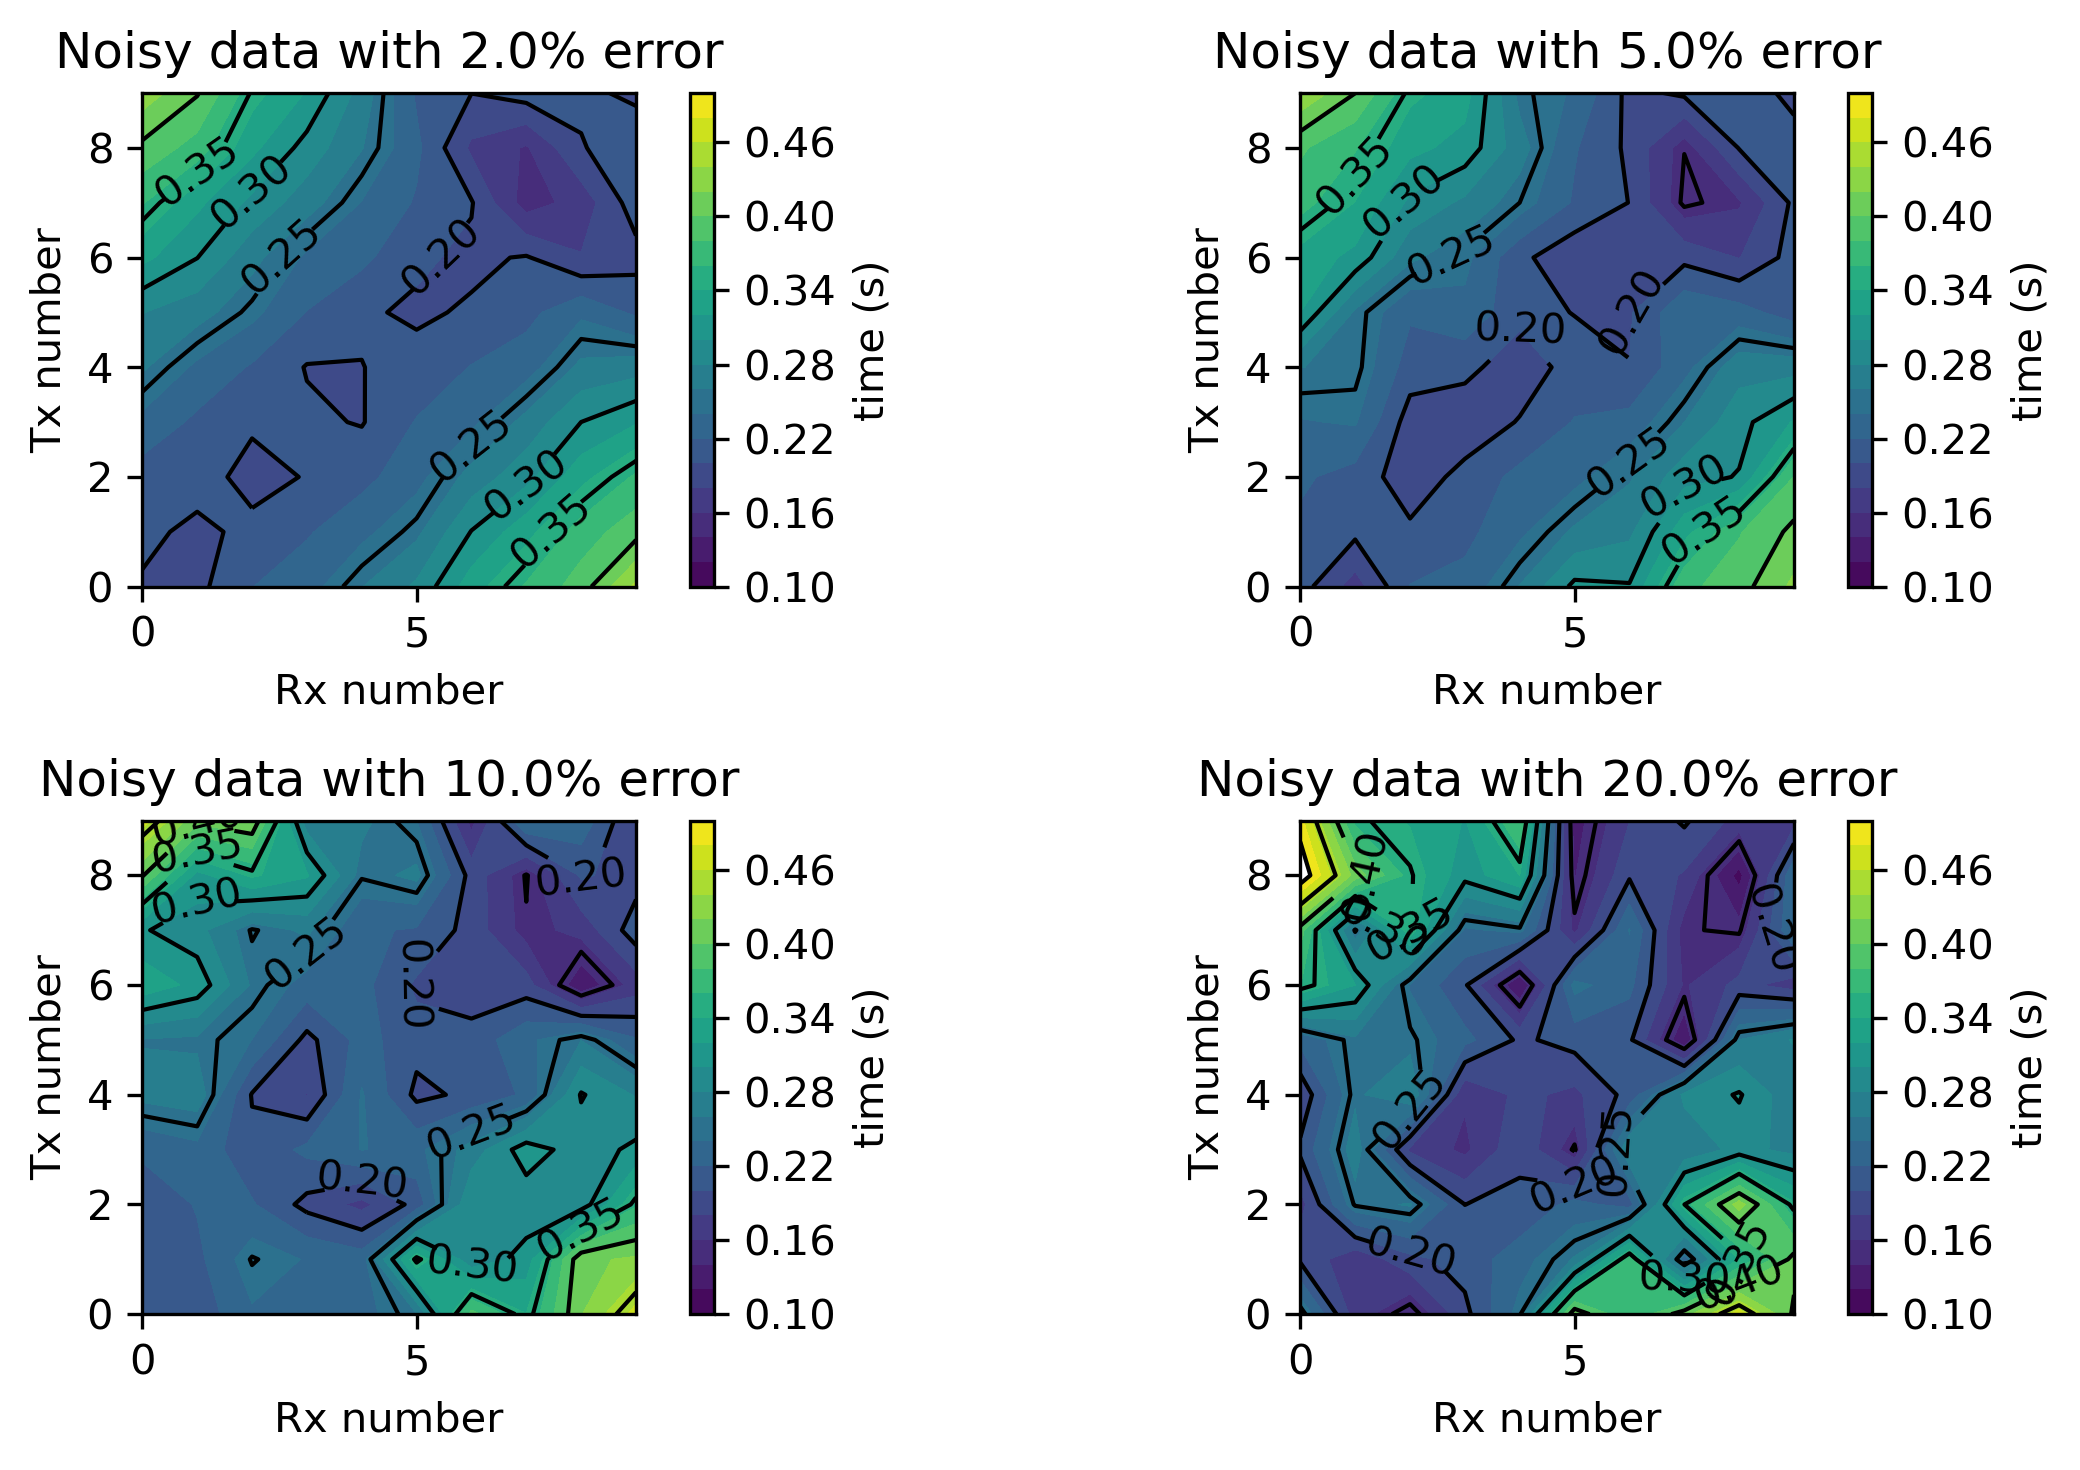

In [15]:
relative_error = [0.02,0.05,0.1,0.2]
fig, ax = plt.subplots(2, 2, figsize=(8, 5), dpi=300)
for i in range(4):
    shifted_noisy_data = shifted_clean_data + np.random.randn(len(clean_data)) * relative_error[i] * np.abs(clean_data)
    plot_data(ax.flatten()[i], shifted_noisy_data, f"Noisy data with {relative_error[i]*100}% error",contour=True)
plt.tight_layout()


# Q2
In this question, we will explore solving the inverse problem using a "smoothest model" approach. Position the block near the center of the domain and add noise at a level where you are still confident where we can detect the target in our data.

Q2.a) Start by setting up a "smoothest" model inversion. Using an accurate estimate of the uncertainties. Describe your setup. Generate plots of the Tikhonov curves. Select an iteration that adequately fits the data and show the observed and predicted data, and their difference. Finally plot the recovered model. Describe why you picked this model.

In [43]:
## set up the inversion
relative_error = 0.02
noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=relative_error)


In [50]:
def run_inversion(mesh, data_object, simulation, smallness=None,alpha_s=None,alpha_x=None,alpha_y=None):
    dmis = data_misfit.L2DataMisfit(data_object, simulation)
    # Set up the regularization
    if alpha_x is None:
        alpha_x = 1
    if alpha_y is None:
        alpha_y = 1
    #smallness
    if alpha_s is None:
        alpha_s = 1/mesh.h[0][0]**2

    reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
    reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
    reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")

    if smallness is None:
        alpha_s = 1e-6
        reg = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y
    else:
        reg = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y

    opt = optimization.ProjectedGNCG(lower=0.0, maxIter=30)
    invprob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    chifact=0.1
    beta0_ratio=1e3
    coolingFactor=2

    save = directives.SaveOutputDictEveryIteration()
    beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
    beta_schedule = directives.BetaSchedule(
        coolingFactor=coolingFactor, coolingRate=1
    )
    # target = directives.TargetMisfit(chifact=chifact)
    directives_list = [
        beta_estimate,
        beta_schedule,
        save
    ]
    inv = inversion.BaseInversion(invprob, directives_list)
    m0 = background_slowness_model
    mopt = inv.run(m0)

    return save, mopt

In [51]:
save, mopt = run_inversion(mesh=mesh, data_object=data_object, simulation=simulation,smallness=None)


SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.76e+10  8.73e+02  0.00e+00  8.73e+02    3.45e+04      0              
   1  3.38e+10  5.73e+02  3.67e-10  5.85e+02    1.15e+05      0              
   2  1.69e+10  5.40e+02  1.08e-09  5.59e+02    1.12e+05      0   Skip BFGS  
   3  8.46e+09  4.93e+02  3.12e-09  5.20e+02    1.06e+05      0   Skip BFGS  
   4  4.23e+09  4.35e+02  8.12e-09  4.69e+02    9.98e+04      0   Skip BFGS  
   5  2.11

In [52]:
def plot_tikhonov_curves(beta_values, phi_d, phi_m, phid_star=None, iteration=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12,3))
    
    ax[0].plot(beta_values, phi_d)
    ax[1].plot(beta_values, phi_m)
    ax[2].plot(phi_m, phi_d)

    if phid_star is not None: 
        ax[0].plot(beta_values, np.ones_like(beta_values) * phid_star, "--k")

    ax[0].set_ylabel("$\\phi_d$")
    ax[1].set_ylabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    ax[2].set_xlabel("$\\phi_m$")
    
    if iteration is not None: 
        ax[0].plot(beta_values[iteration], phi_d[iteration], "C3o")
        ax[1].plot(beta_values[iteration], phi_m[iteration], "C3o")
        ax[2].plot(phi_m[iteration], phi_d[iteration], "C3o")

    for a in ax[:2]:
        a.invert_xaxis()
        a.set_xlabel("$\\beta$")
    plt.tight_layout()
    
    return ax

In [53]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

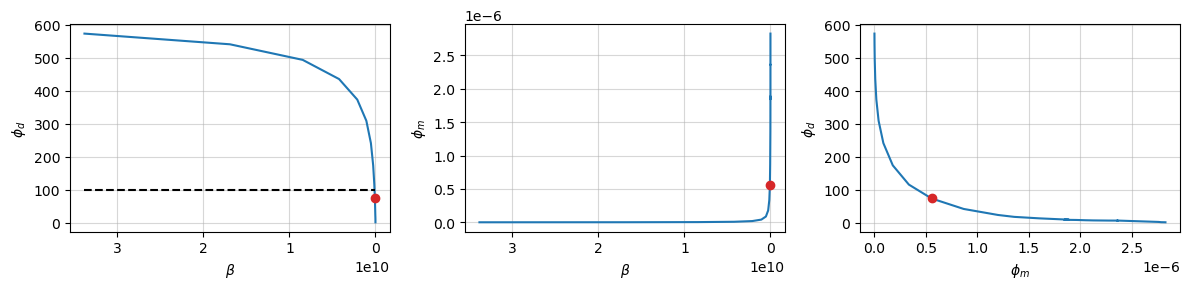

In [57]:
iteration = 9
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: title={'center': 'Recovered model'}, xlabel='x', ylabel='y'>

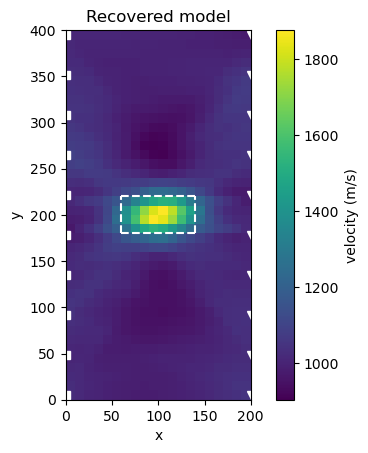

In [58]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
plot_outline(plt.gca())


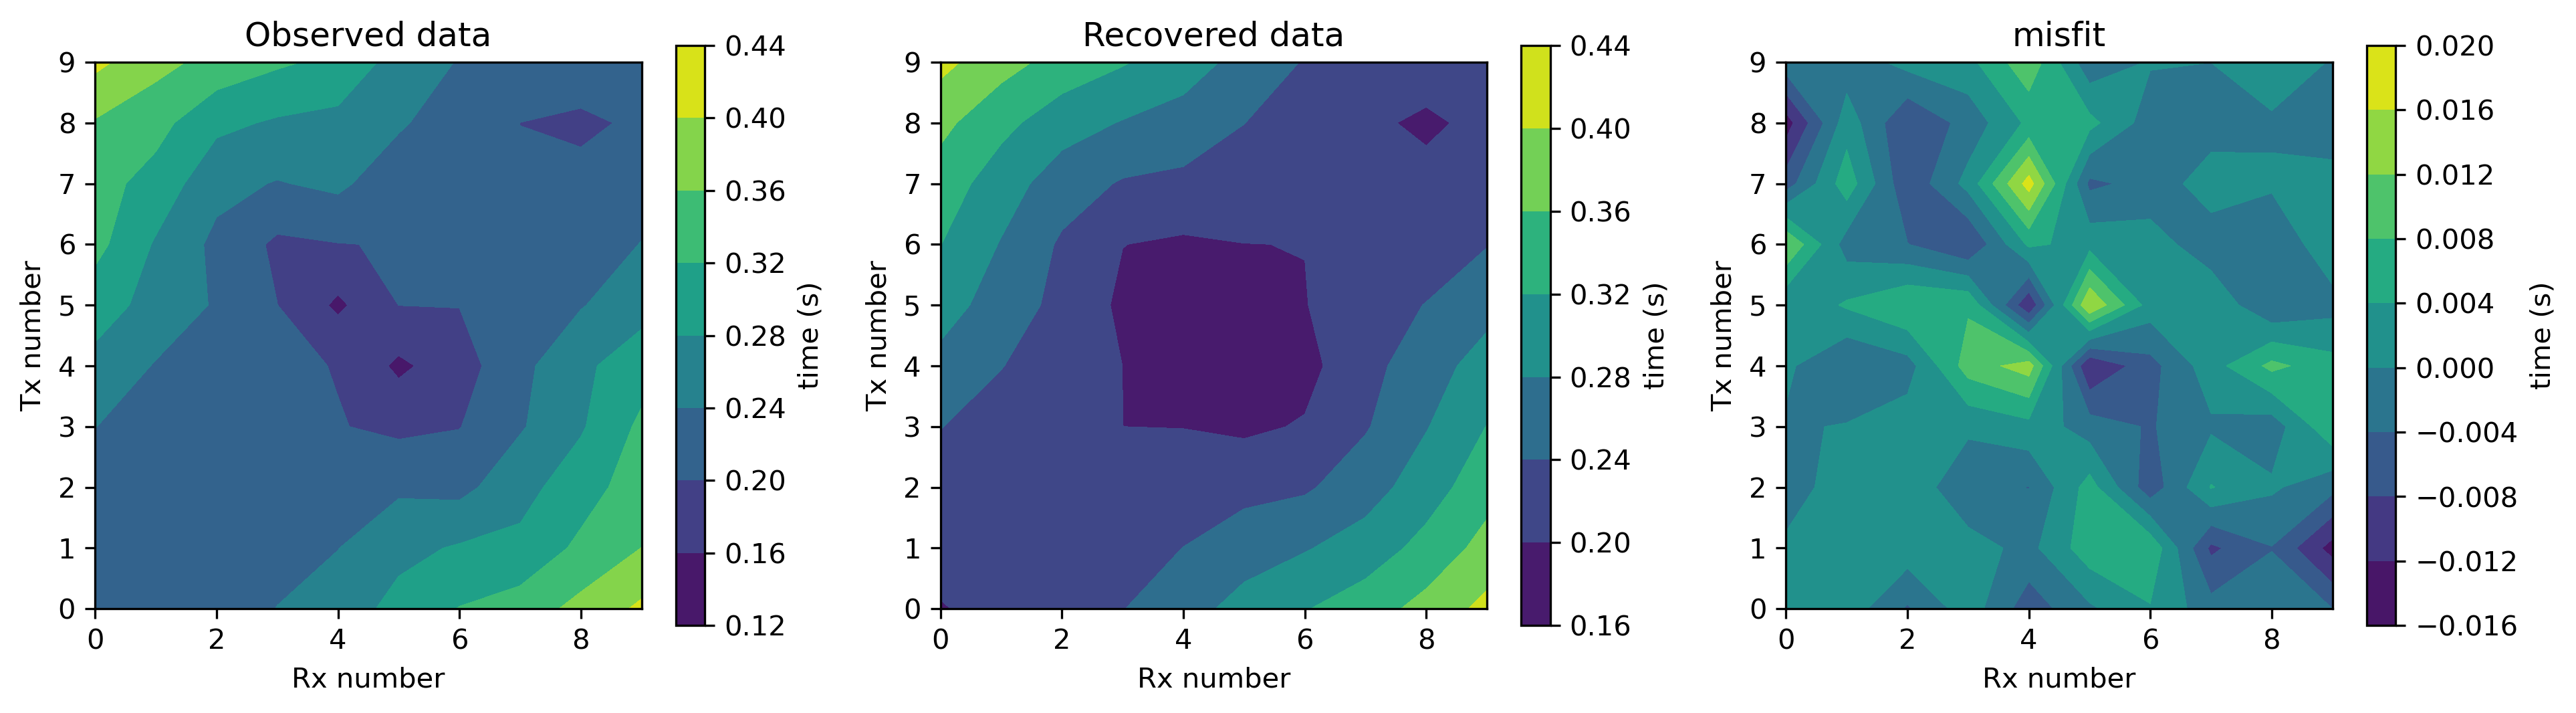

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
recovered_data = simulation.dpred(models[iteration])
difference = noisy_data - recovered_data
for i, dplot in enumerate([noisy_data, recovered_data, difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()

# Q2.b
Now, lets explore that happens if an incorrect noise level is used. When creating the \texttt{data} object that is used in the inverse, lets set the`relative_error` to be too large. Choose `relative_error=2*true_elative_error`. Plot the Tikhonov curves. Select an interation that is close to the data misfit. What features in the Tikhonov curves, data, and model suggest that we are under-fitting the data? Based on this, why might you want to run an inversion past a $\chi$-factor of 1?

In [60]:
relative_error = 2*0.02
#noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=data_object, simulation=simulation,smallness=None)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]


SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.72e+10  2.18e+02  0.00e+00  2.18e+02    8.63e+03      0              
   1  8.62e+09  1.43e+02  3.56e-10  1.46e+02    2.88e+04      0              
   2  4.31e+09  1.35e+02  1.04e-09  1.40e+02    2.80e+04      0   Skip BFGS  
   3  2.16e+09  1.24e+02  3.03e-09  1.30e+02    2.66e+04      0   Skip BFGS  
   4  1.08e+09  1.09e+02  7.91e-09  1.18e+02    2.50e+04      0   Skip BFGS  
   5  5.39

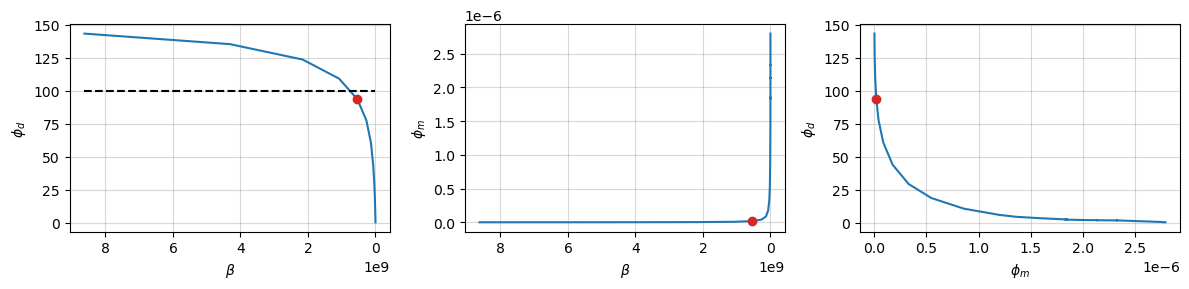

In [73]:
iteration = 4
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: title={'center': 'Recovered model'}, xlabel='x', ylabel='y'>

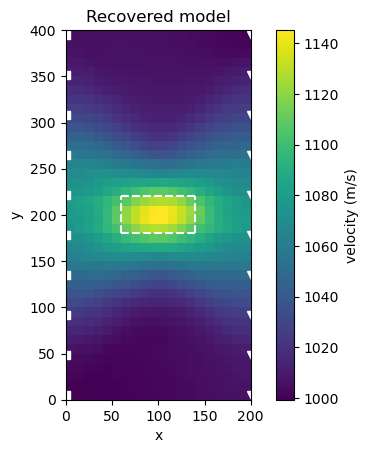

In [74]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
plot_outline(plt.gca())

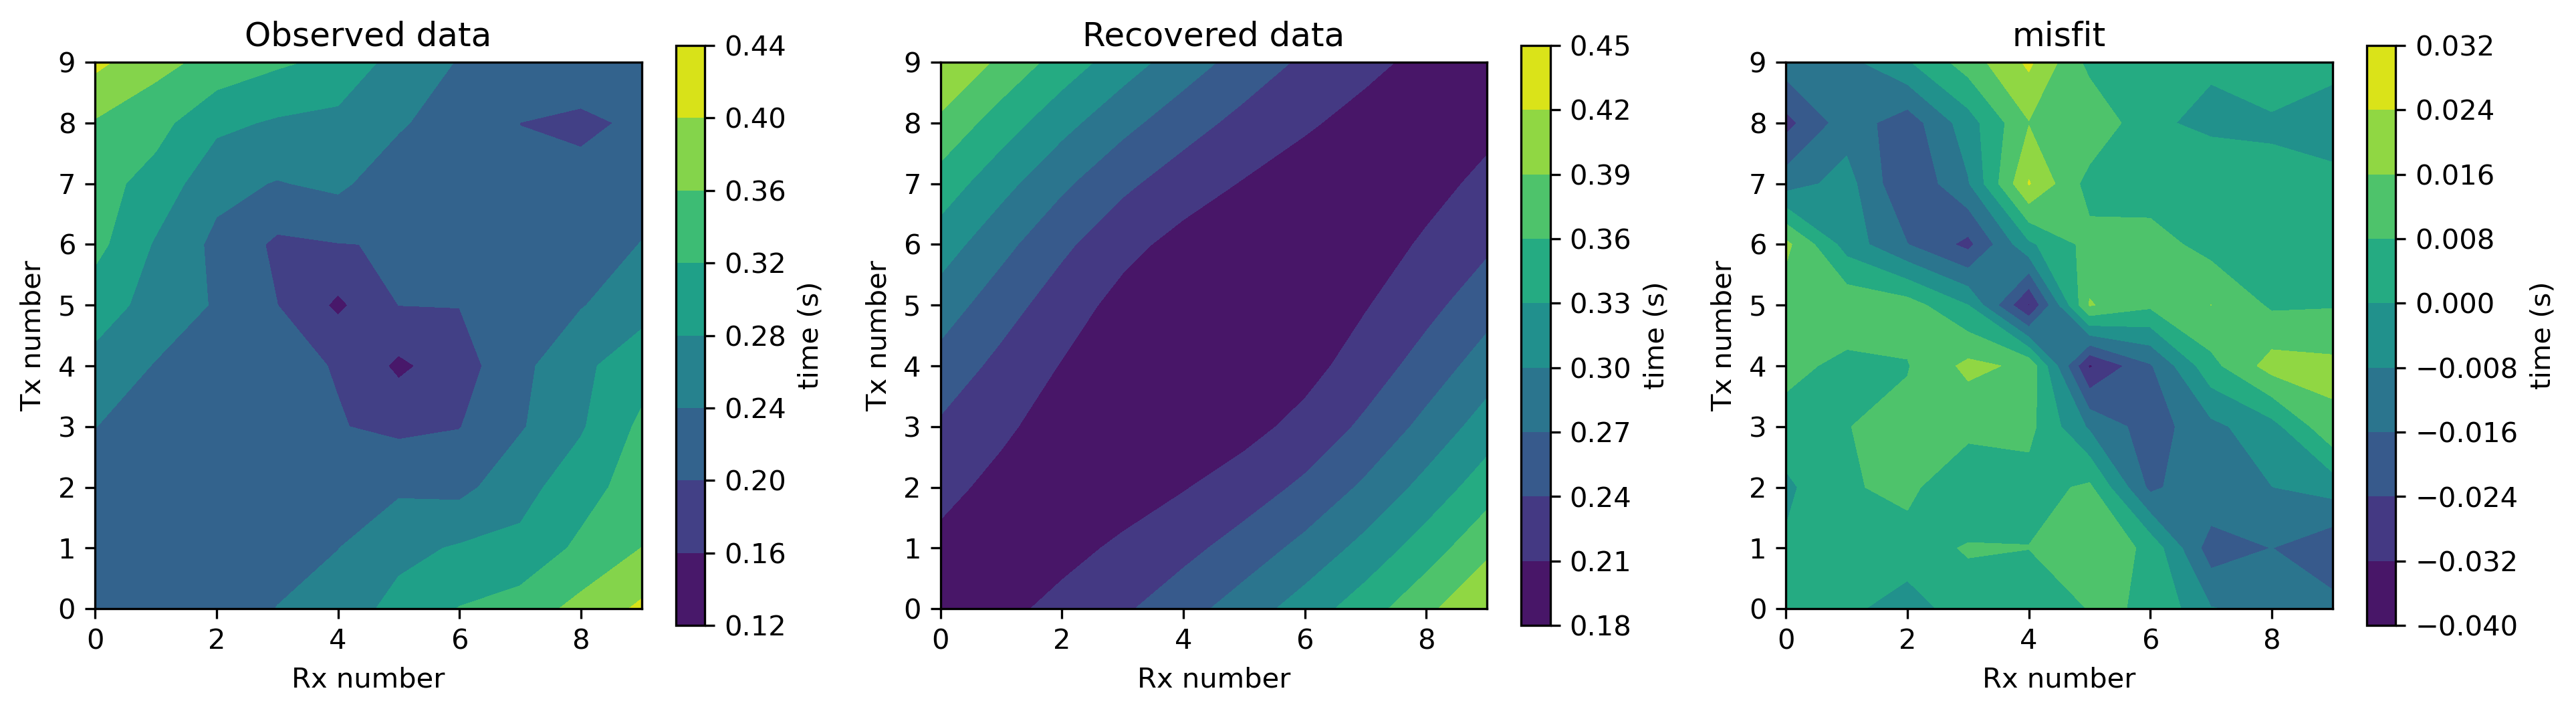

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
recovered_data = simulation.dpred(models[iteration])
difference = noisy_data - recovered_data
for i, dplot in enumerate([noisy_data, recovered_data, difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()#

# Q2.c
Now, lets explore that happens if an incorrect noise level is used. When creating the `data` object that is used in the inverse, lets set the `relative_error` to be too small. Choose `relative_error=0.1*true_relative_error`. Plot the Tikhonov curves.
Select an interation that is either close to the data misfit or where the data misfit levels off (you can try increasing the `maxIter` to increase the maximum number of iterations that the inversion takes).
What features in the Tikhonov curves, data, and model suggest that we are over-fitting the data? Look back to some earlier iterations. When does it start to become obvious that you are over-fitting the data?

In [91]:
relative_error = 0.02
noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=0.1*relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=data_object, simulation=simulation,smallness=None)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]


SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.86e+12  7.75e+04  0.00e+00  7.75e+04    2.36e+06      0              
   1  3.43e+12  4.92e+04  3.00e-10  5.02e+04    1.02e+07      0              
   2  1.71e+12  4.66e+04  8.56e-10  4.81e+04    1.00e+07      0   Skip BFGS  
   3  8.57e+11  4.28e+04  2.47e-09  4.49e+04    9.58e+06      0   Skip BFGS  
   4  4.28e+11  3.81e+04  6.46e-09  4.09e+04    9.10e+06      0   Skip BFGS  
   5  2.14

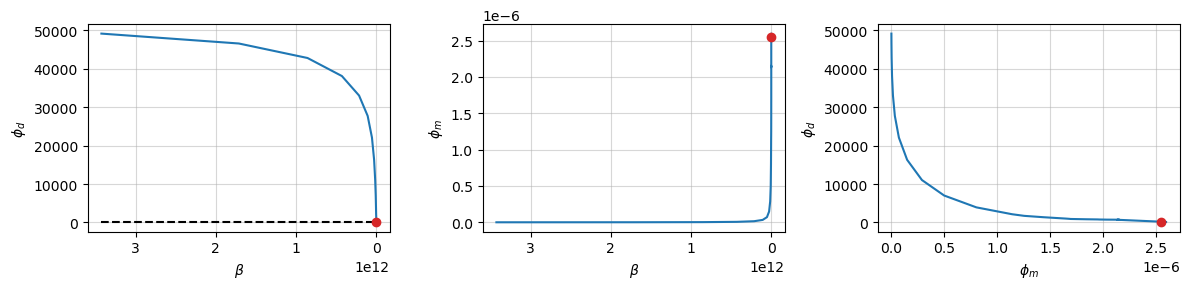

In [92]:
iteration = 29
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: title={'center': 'Recovered model'}, xlabel='x', ylabel='y'>

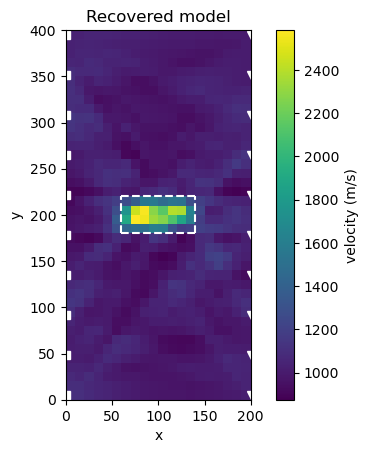

In [93]:
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
plot_outline(plt.gca())

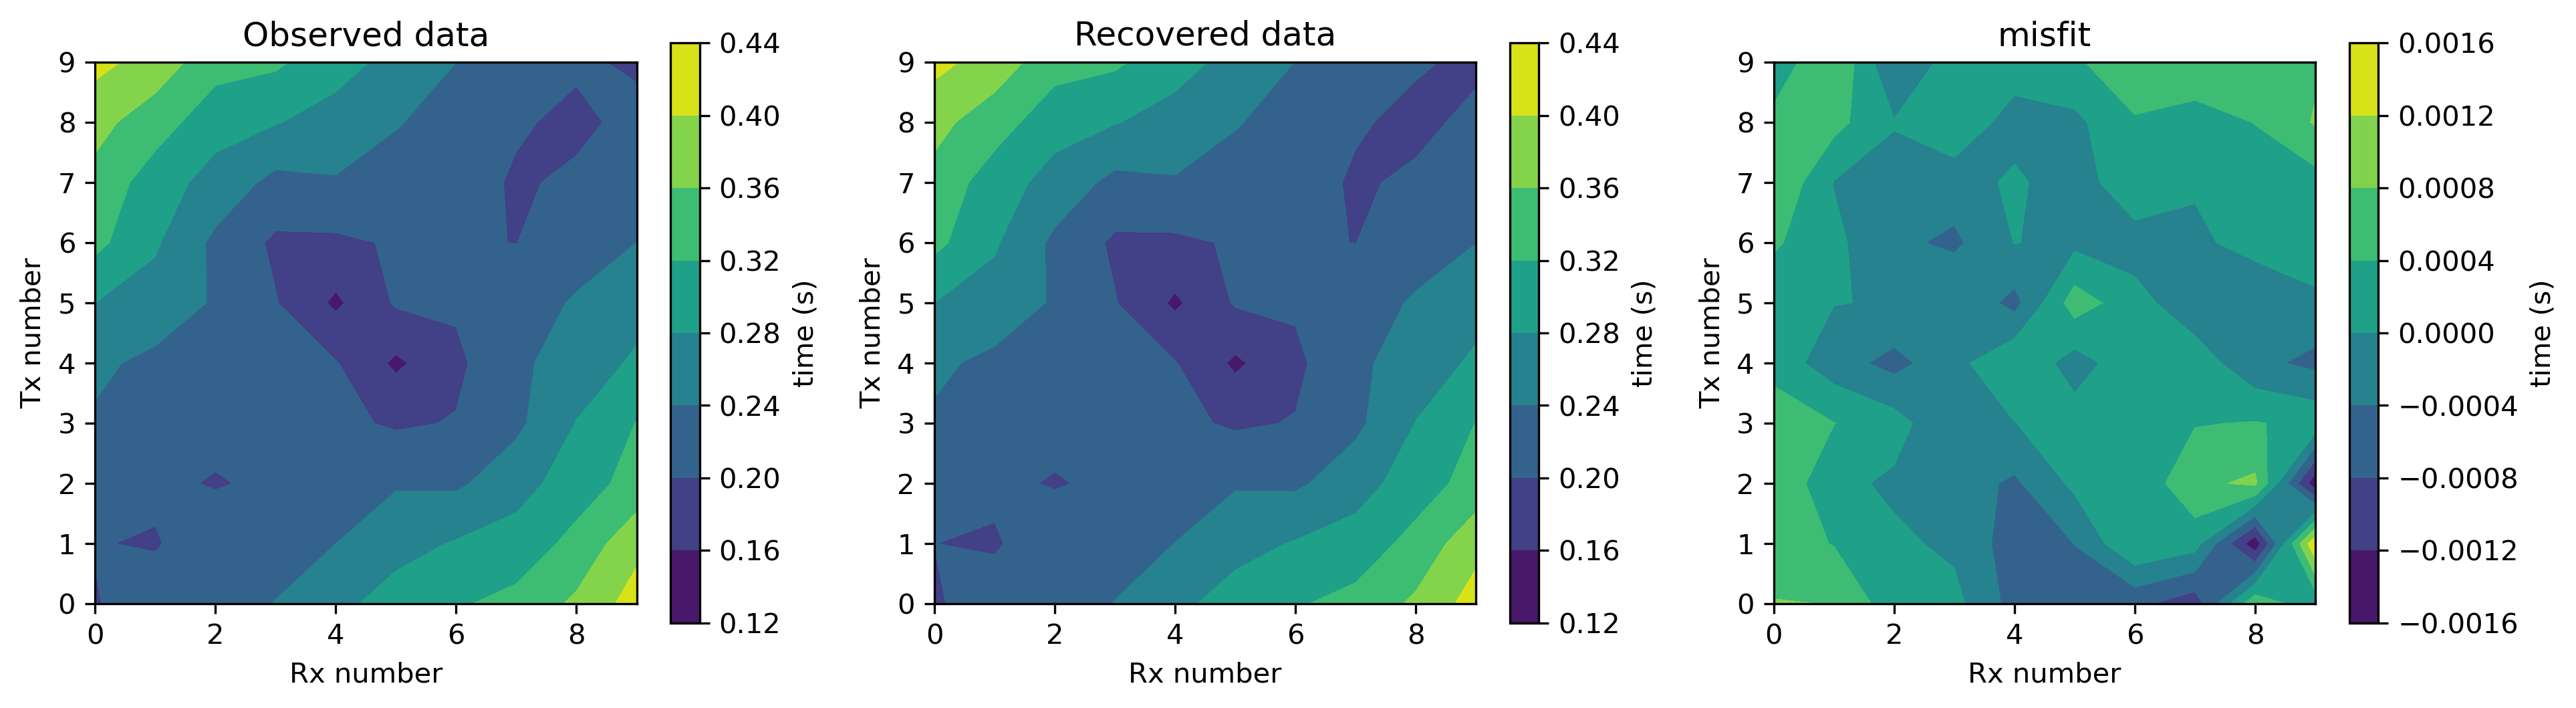

In [94]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
recovered_data = simulation.dpred(models[iteration])
difference = noisy_data - recovered_data
for i, dplot in enumerate([noisy_data, recovered_data, difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()#

# Q3
In this question, we will explore solving the inverse problem that balances the $\alpha$-values between the smallest and smoothest regularization terms. Use the same position of the block and noise levels in the data as before.

First, perform an inversion using the correct assignment of uncertainties and show the Tikhonov curves, observed and predicted data and recovered model.

In [97]:
relative_error = 0.02
noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=data_object, simulation=simulation)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]


SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.86e+10  8.28e+02  0.00e+00  8.28e+02    4.05e+04      0              
   1  3.43e+10  5.23e+02  3.60e-10  5.35e+02    1.14e+05      0              
   2  1.71e+10  4.91e+02  1.05e-09  5.09e+02    1.10e+05      0   Skip BFGS  
   3  8.57e+09  4.44e+02  3.04e-09  4.71e+02    1.04e+05      0   Skip BFGS  
   4  4.28e+09  3.87e+02  7.89e-09  4.21e+02    9.69e+04      0   Skip BFGS  
   5  2.14

<Axes: title={'center': 'Recovered model'}, xlabel='x', ylabel='y'>

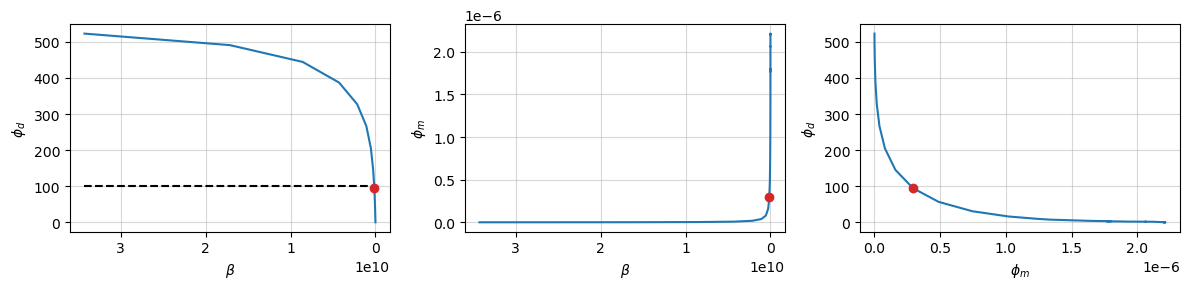

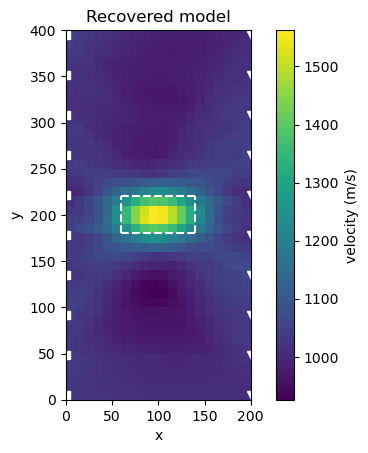

In [100]:
iteration = 8
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
plot_outline(plt.gca())

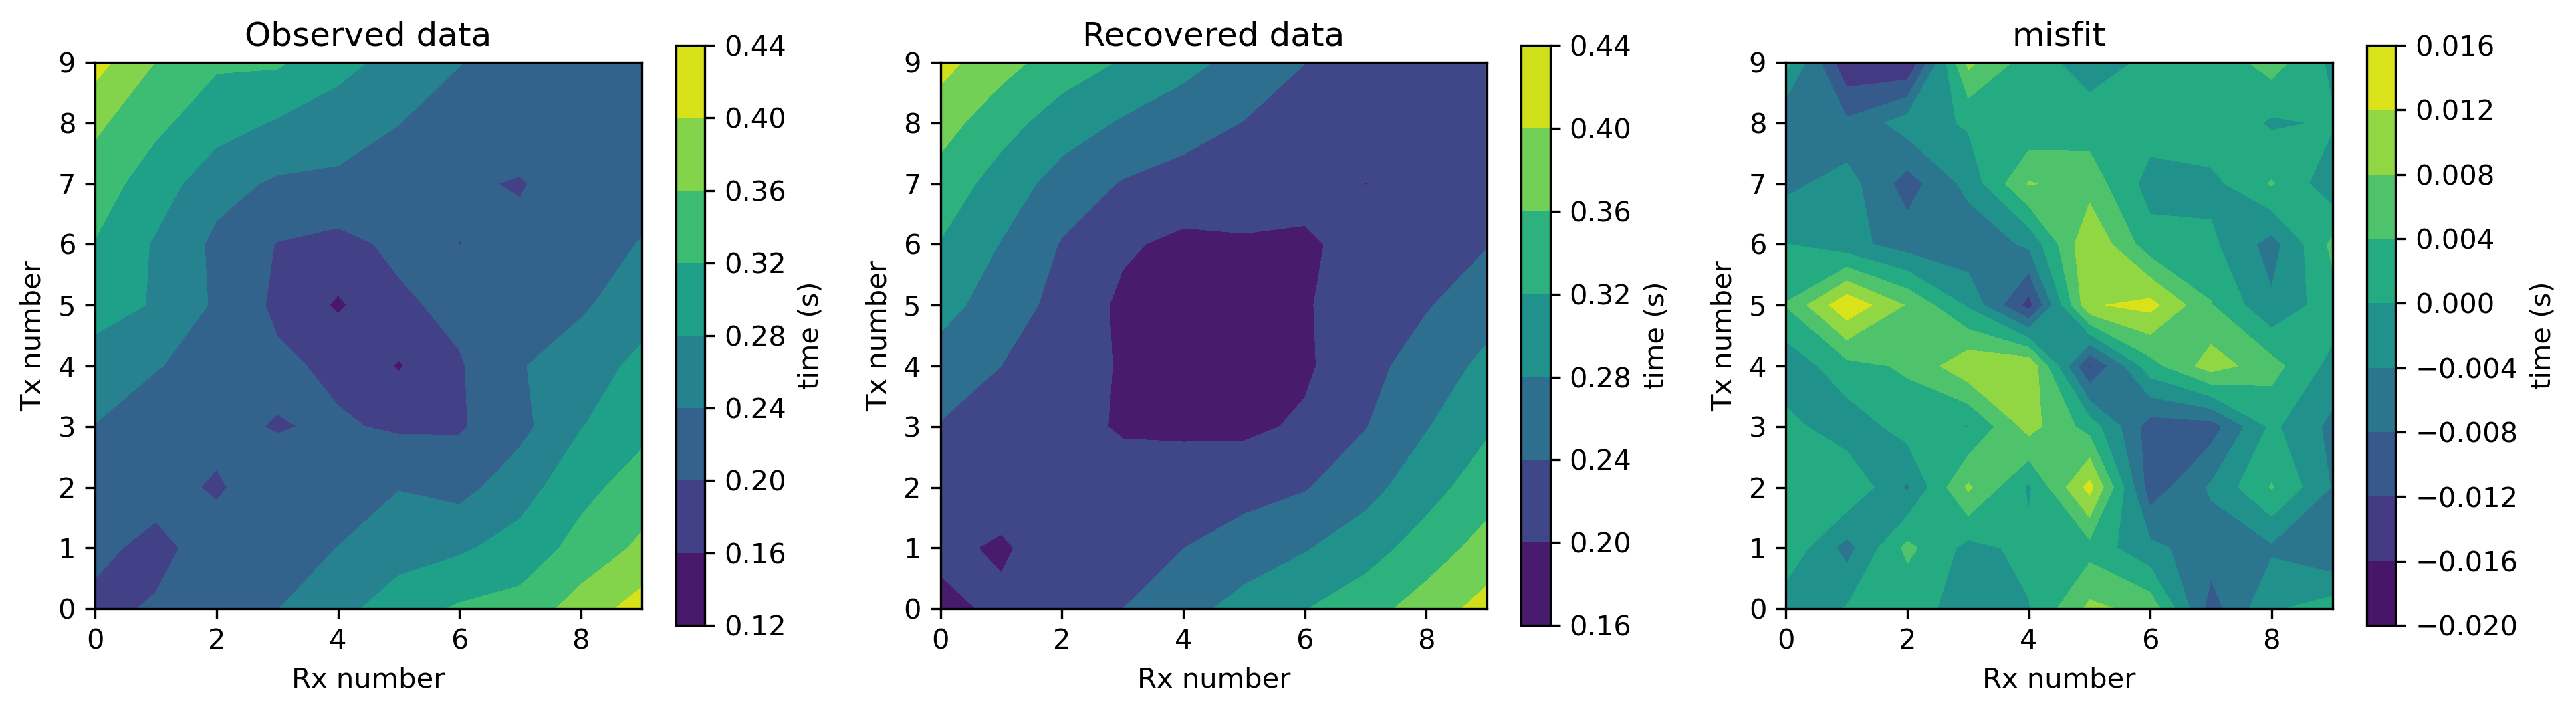

In [102]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
recovered_data = simulation.dpred(models[iteration])
difference = noisy_data - recovered_data
for i, dplot in enumerate([noisy_data, recovered_data, difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()

# Q3.b
Repeat the exercise of over and underestimating the noise when creating the data object that is fed into the inversion. Describe how the results are similar / different than in the previous question.

In [103]:
## Underfitting
relative_error = 2*0.02
#noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=data_object, simulation=simulation,smallness=True)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.50e+10  2.07e+02  0.00e+00  2.07e+02    1.01e+04      0              
   1  7.50e+09  2.05e+02  6.22e-11  2.06e+02    5.10e+03      0              
   2  3.75e+09  2.03e+02  2.46e-10  2.04e+02    5.14e+03      0   Skip BFGS  
   3  1.88e+09  2.00e+02  9.60e-10  2.02e+02    5.22e+03      0   Skip BFGS  
   4  9.38e+08  1.93e+02  3.66e-09  1.96e+02    5.37e+03      0   Skip BFGS  
   5  4.69

Underfit example for smallness and smoothness


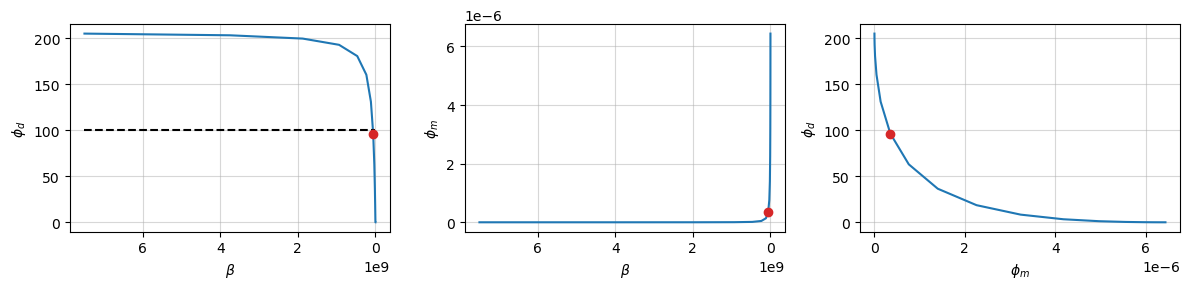

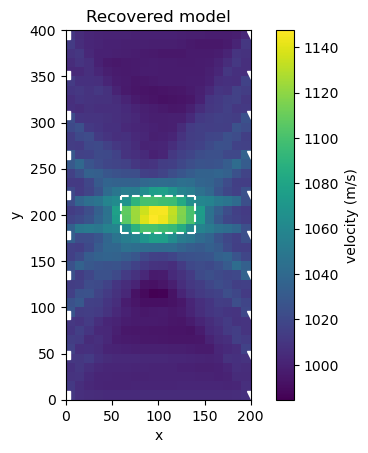

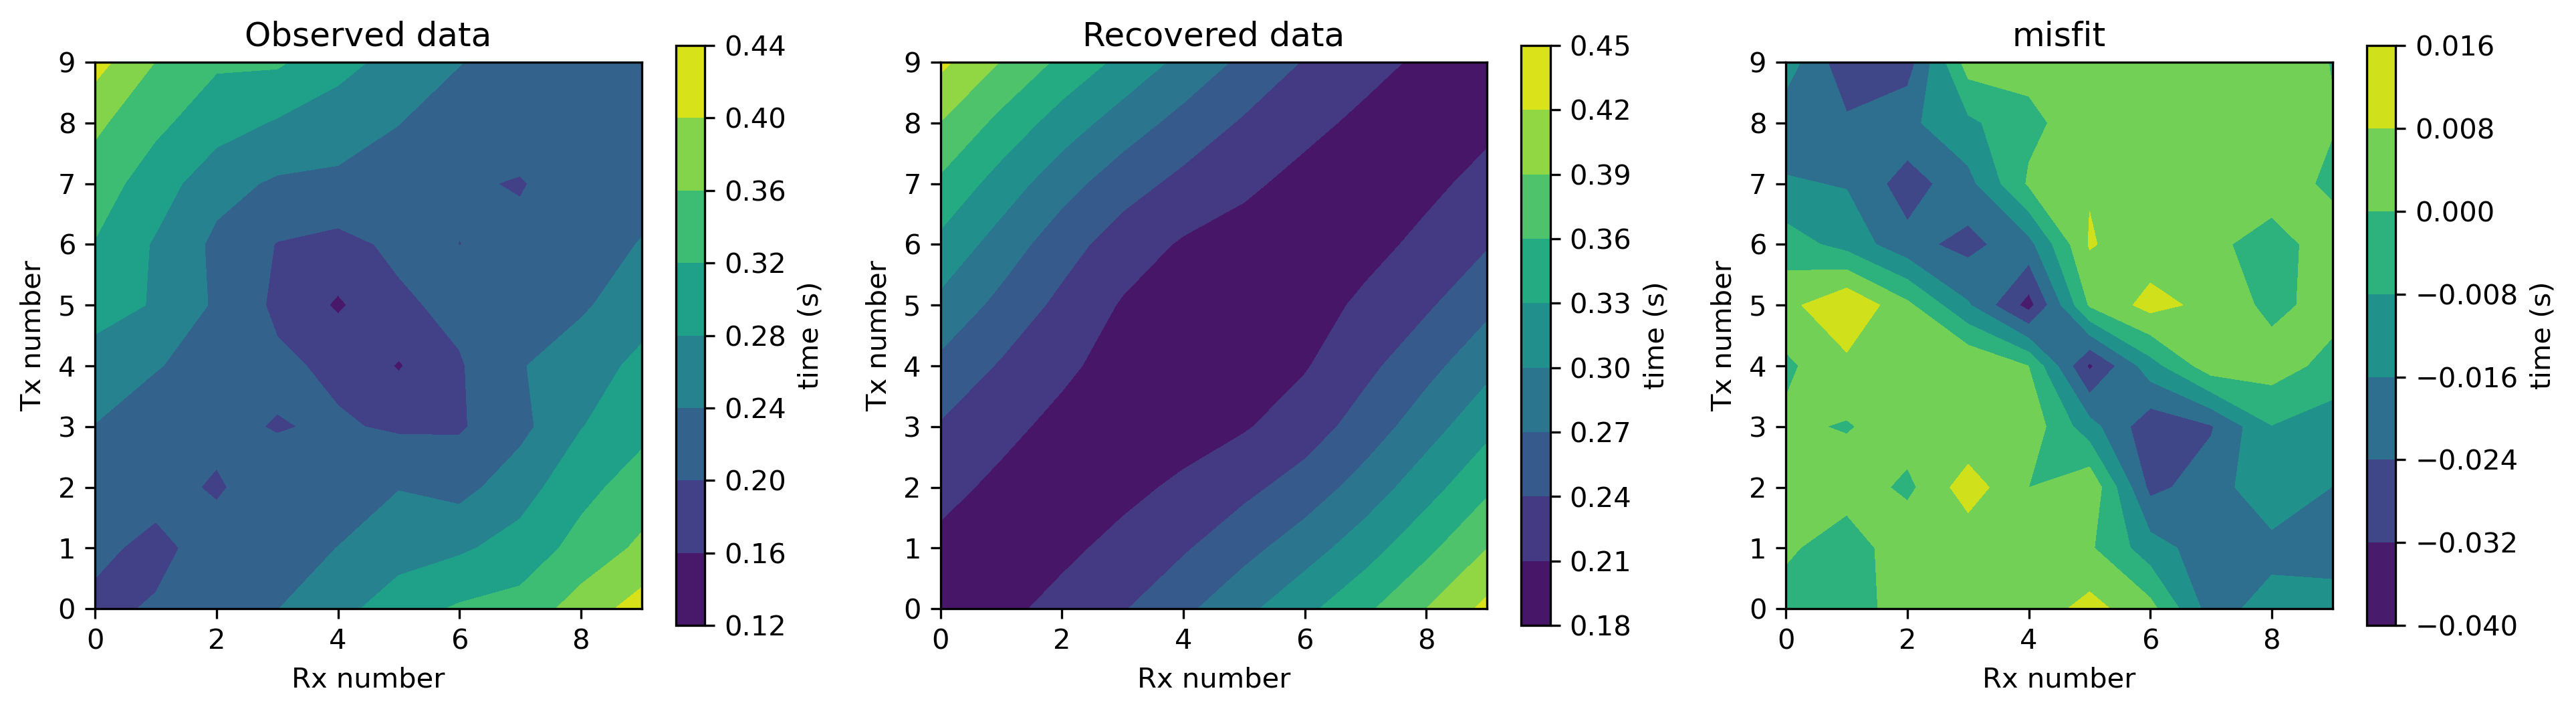

In [104]:
iteration = 7
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
plot_outline(plt.gca())
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
recovered_data = simulation.dpred(models[iteration])
difference = noisy_data - recovered_data
for i, dplot in enumerate([noisy_data, recovered_data, difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()
print("Underfit example for smallness and smoothness")

In [105]:
## Overfitting
relative_error = 0.02
#noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=0.1*relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=data_object, simulation=simulation,smallness=True)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.15e+12  8.28e+04  0.00e+00  8.28e+04    4.05e+06      0              
   1  3.08e+12  8.21e+04  5.92e-11  8.23e+04    2.04e+06      0              
   2  1.54e+12  8.14e+04  2.34e-10  8.17e+04    2.05e+06      0   Skip BFGS  
   3  7.69e+11  8.00e+04  9.14e-10  8.07e+04    2.08e+06      0   Skip BFGS  
   4  3.85e+11  7.73e+04  3.49e-09  7.87e+04    2.14e+06      0   Skip BFGS  
   5  1.92

Overfit example for smallness and smoothness


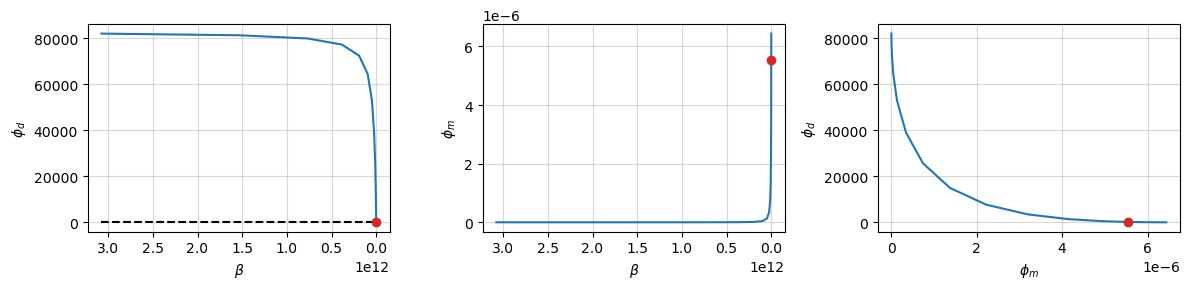

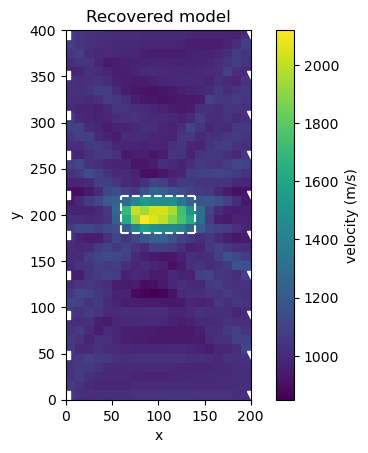

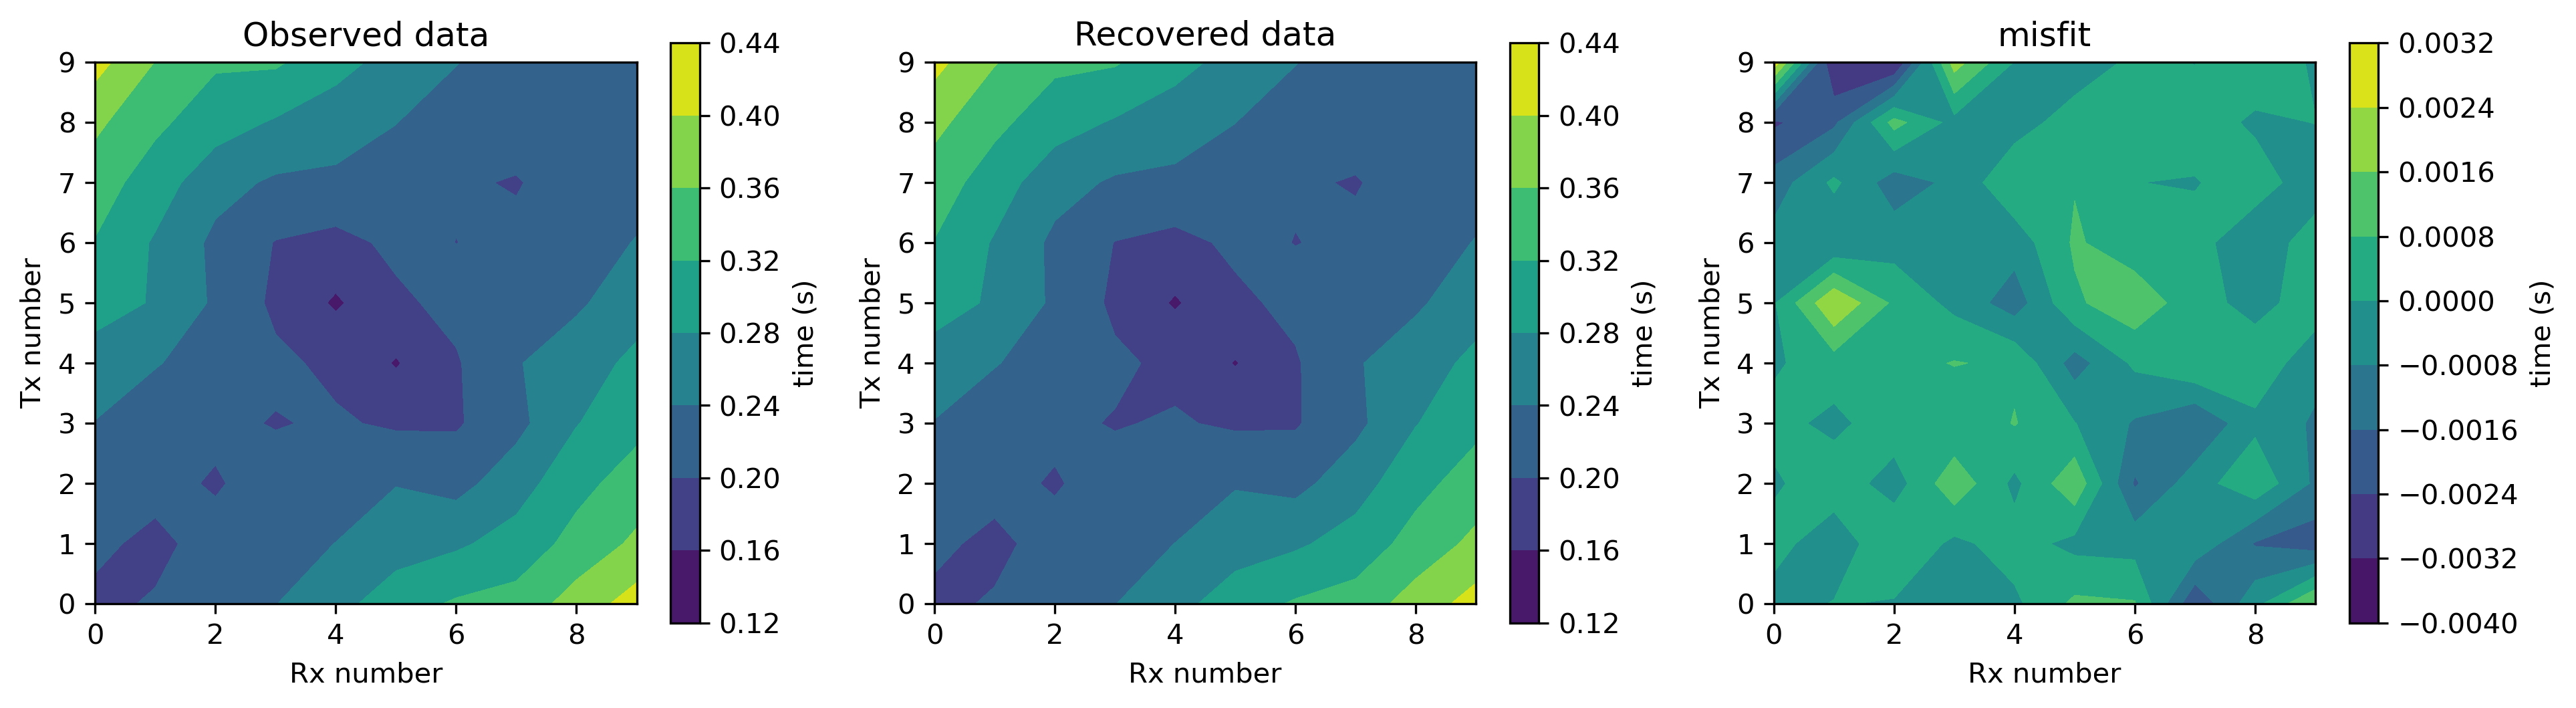

In [106]:
iteration = 14
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
plot_outline(plt.gca())
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
recovered_data = simulation.dpred(models[iteration])
difference = noisy_data - recovered_data
for i, dplot in enumerate([noisy_data, recovered_data, difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()

print("Overfit example for smallness and smoothness")

# Q3.c
When first encountering a new data set, would you recommend starting with balanced $\alpha$-values, or a smoothest model approach? What is your reasoning?


Now set the noise levels back to the appropriate choice. Try substantially increasing $\alpha_x$ while keeping $\alpha_y=1$. Plot the resultant model that fits the data and describe why you see the features you see in the recovered model.

In [107]:
relative_error = 0.02
#noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=data_object, simulation=simulation, alpha_x=1e3)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]


SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.29e+08  8.28e+02  0.00e+00  8.28e+02    4.05e+04      0              
   1  6.44e+07  2.43e+02  1.64e-07  2.53e+02    1.45e+05      0              
   2  3.22e+07  2.15e+02  3.35e-07  2.26e+02    1.23e+05      0   Skip BFGS  
   3  1.61e+07  2.04e+02  5.02e-07  2.12e+02    1.21e+05      0   Skip BFGS  
   4  8.05e+06  1.99e+02  6.29e-07  2.04e+02    1.29e+05      0              
   5  4.03

\alpha_x=1e3


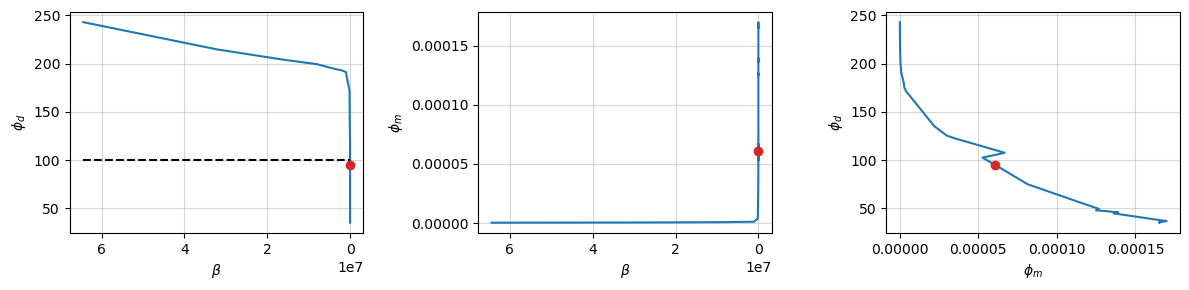

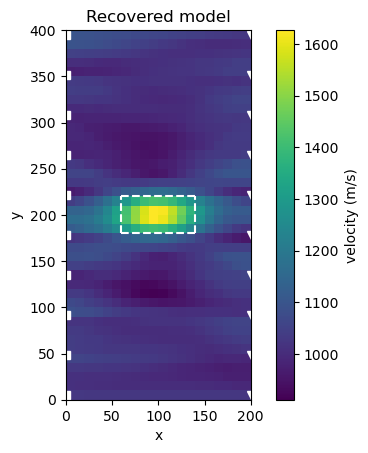

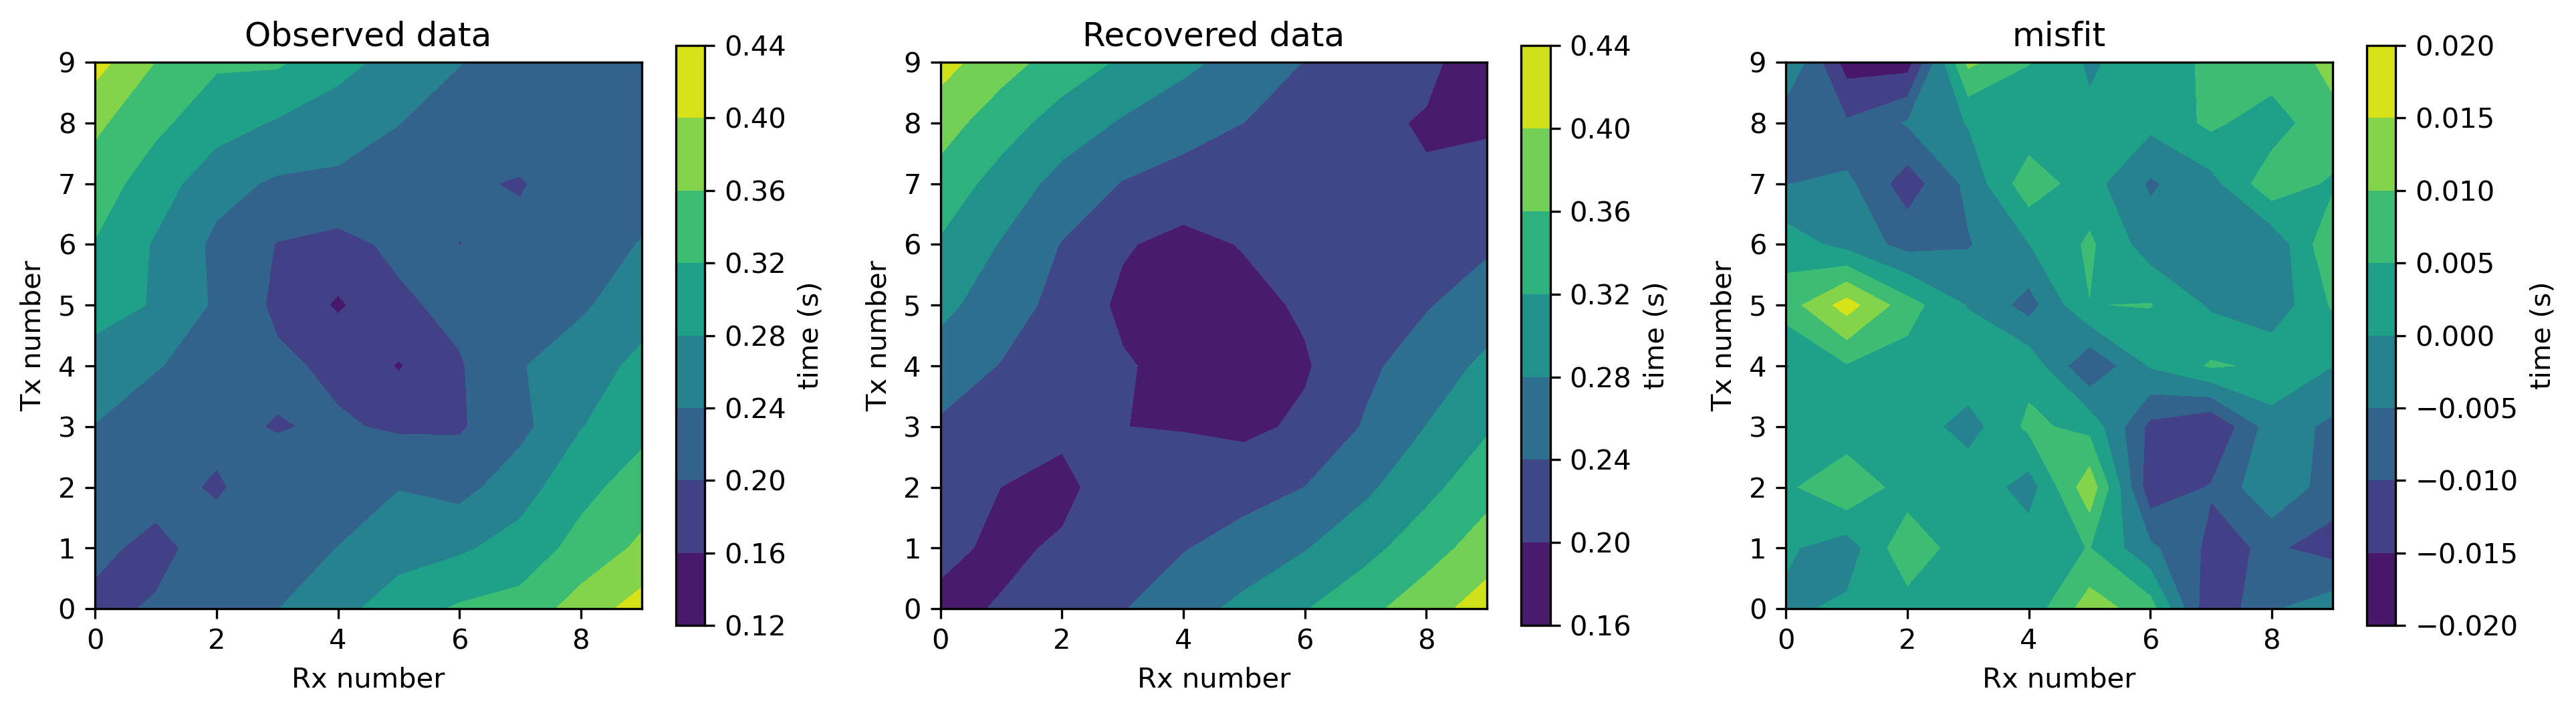

In [113]:
iteration = 16
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
plot_outline(plt.gca())
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
recovered_data = simulation.dpred(models[iteration])
difference = noisy_data - recovered_data
for i, dplot in enumerate([noisy_data, recovered_data, difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()

print("\\alpha_x=1e3")

# Q3.d
Now set the noise levels back to the appropriate choice. Try substantially increasing $\alpha_y$ while keeping $\alpha_x=1$. Plot the resultant model that fits the data and describe why you see the features you see in the recovered model.

In [114]:
relative_error = 0.02
#noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=data_object, simulation=simulation, alpha_y=1e3)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]


SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.29e+08  8.28e+02  0.00e+00  8.28e+02    4.05e+04      0              
   1  6.45e+07  5.38e+02  9.79e-08  5.45e+02    1.19e+05      0              
   2  3.22e+07  5.16e+02  3.57e-07  5.27e+02    1.15e+05      0   Skip BFGS  
   3  1.61e+07  4.79e+02  1.21e-06  4.98e+02    1.10e+05      0   Skip BFGS  
   4  8.06e+06  4.25e+02  3.65e-06  4.55e+02    1.02e+05      0   Skip BFGS  
   5  4.03

\alpha_x=1e3


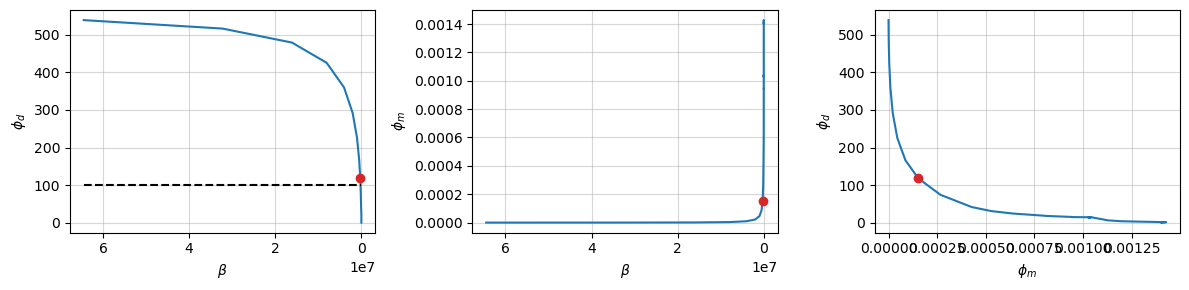

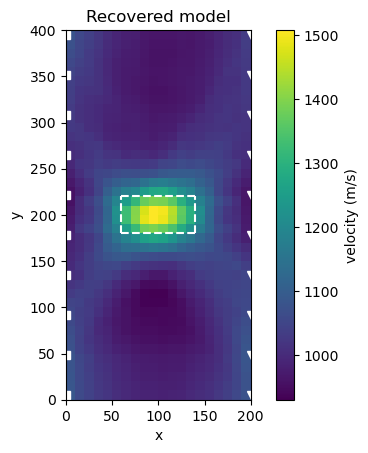

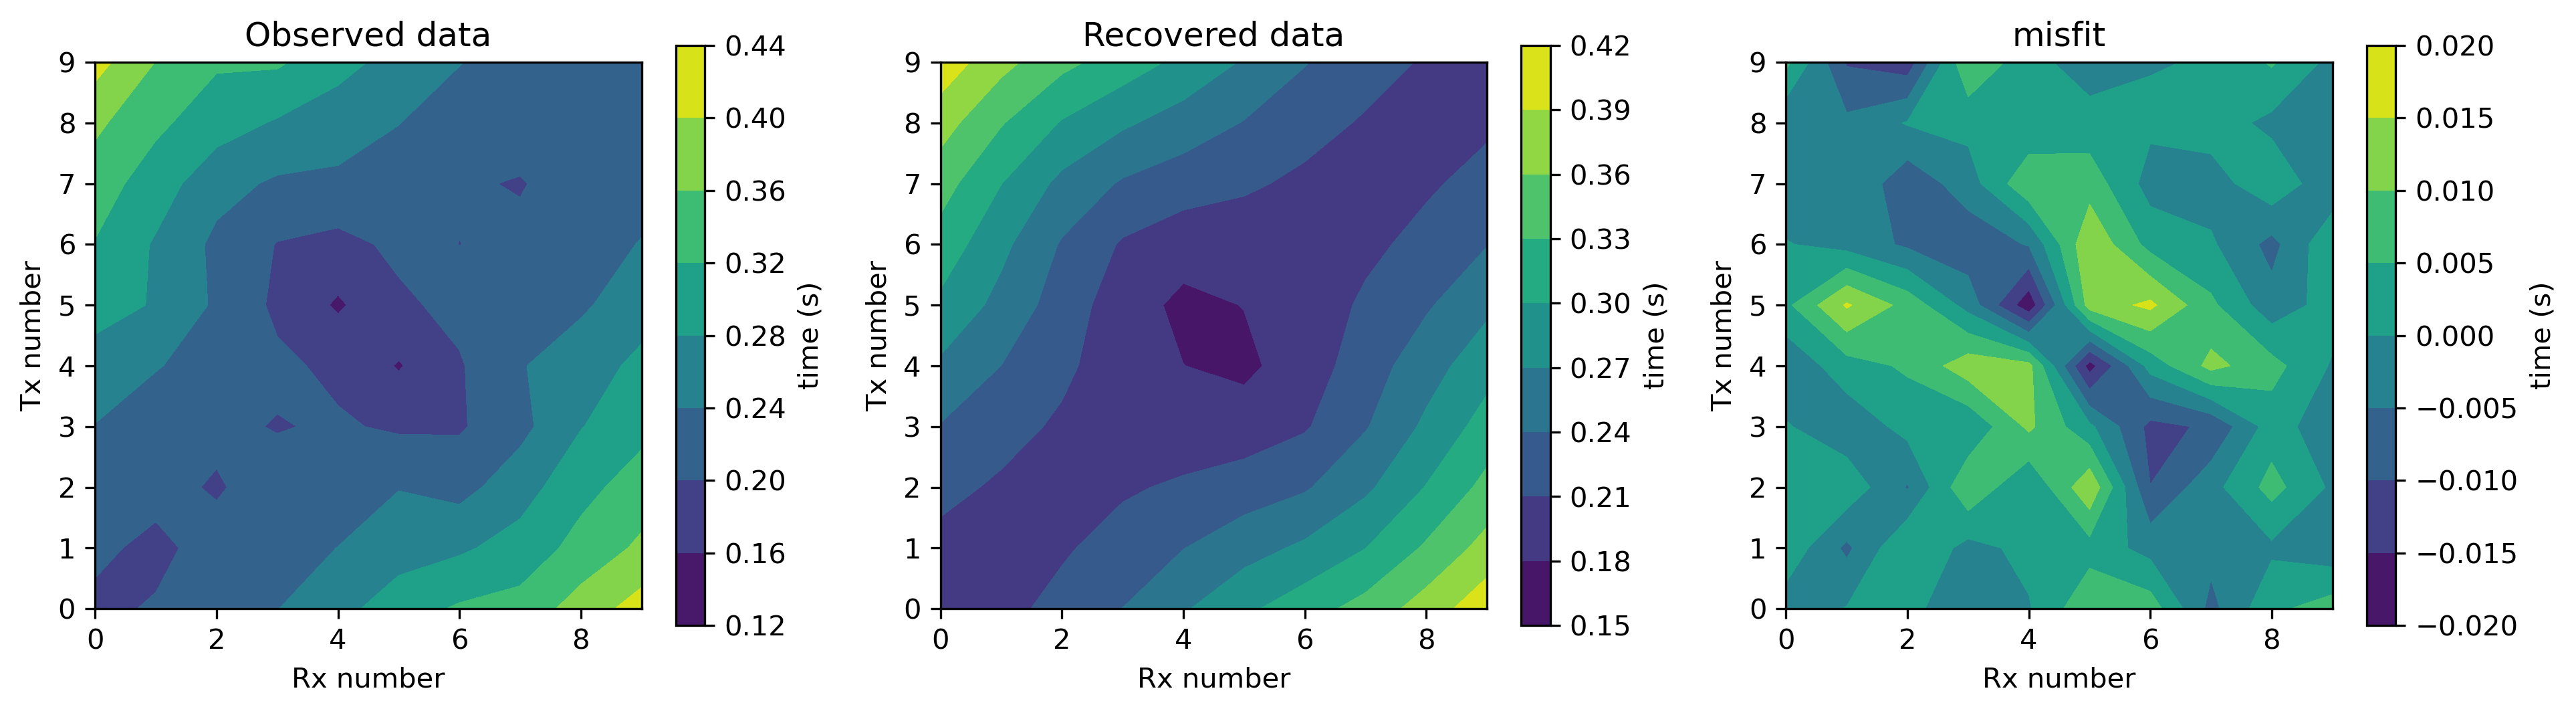

In [115]:
iteration = 8
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
plot_outline(plt.gca())
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
recovered_data = simulation.dpred(models[iteration])
difference = noisy_data - recovered_data
for i, dplot in enumerate([noisy_data, recovered_data, difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()

print("\\alpha_x=1e3")

# Q4
Now, lets move the block. Position it so that it is within the top 100m of our survey area. Keep the rest of the model parameters the same.
Run a smoothest model inversion using the appropriate assignment of uncertainties. Plot the Tikhonov curves, predicted and observed data and recovered model that fits the data. Describe what is similar and different to the result obtained when the target is in the center of the target region? Why might this be the case?

In [116]:
relative_error = 0.02
shifted_noisy_data = shifted_clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
data_object = data.Data(tomo_survey, dobs=shifted_noisy_data, relative_error=relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=data_object, simulation=simulation,smallness=None)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]


SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.42e+10  7.22e+02  0.00e+00  7.22e+02    4.23e+04      0              
   1  3.21e+10  4.71e+02  8.31e-10  4.97e+02    1.03e+05      0              
   2  1.60e+10  4.21e+02  1.95e-09  4.52e+02    9.77e+04      0   Skip BFGS  
   3  8.02e+09  3.75e+02  4.02e-09  4.07e+02    9.38e+04      0   Skip BFGS  
   4  4.01e+09  3.33e+02  7.78e-09  3.64e+02    9.08e+04      0   Skip BFGS  
   5  2.01

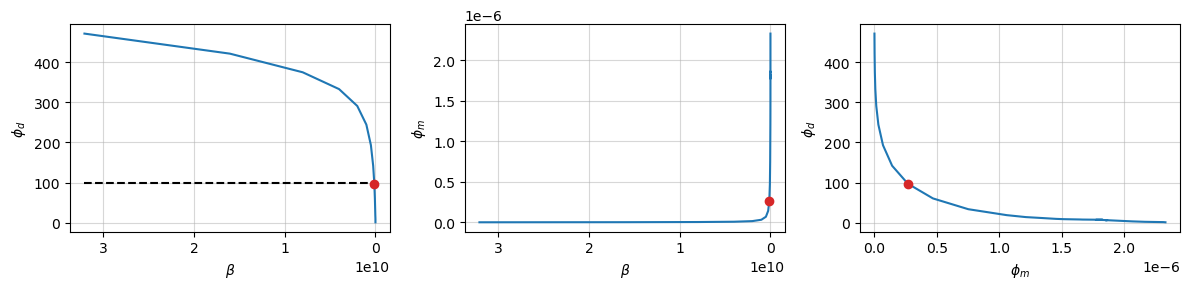

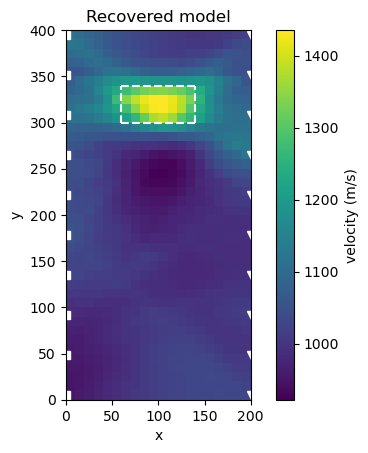

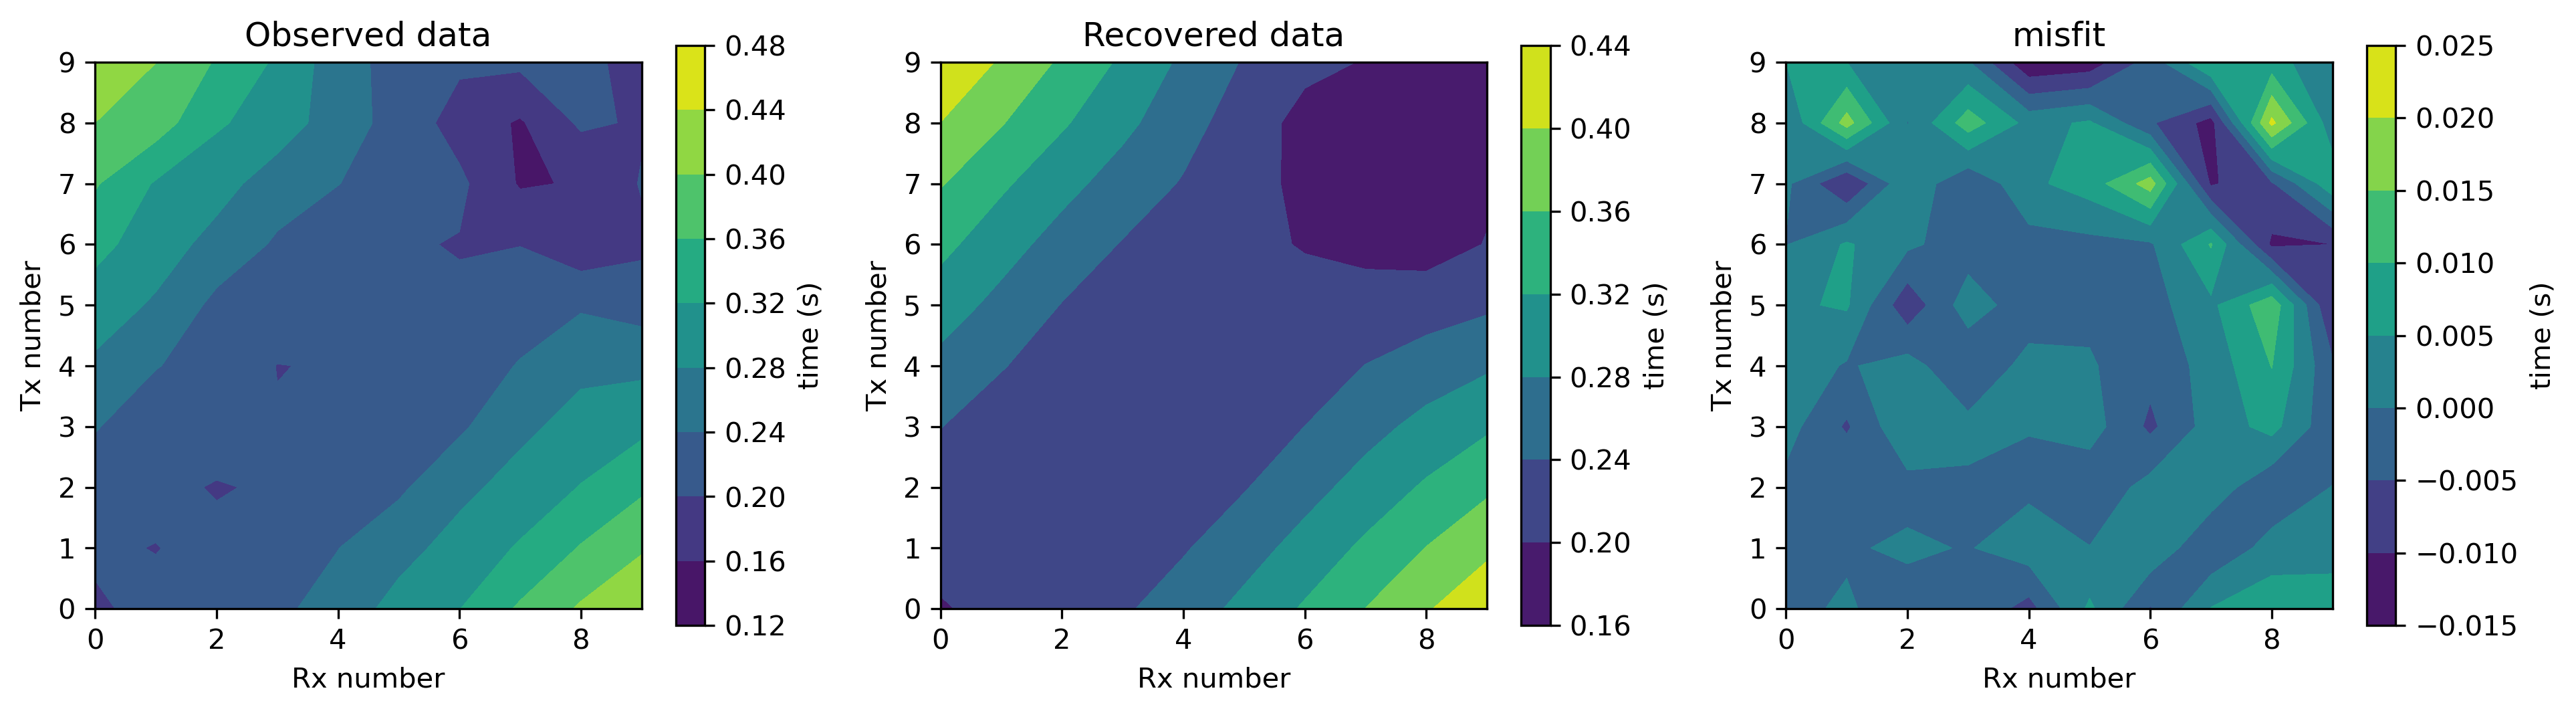

In [119]:
iteration = 8
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(shifted_noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
plot_outline(plt.gca(),y=shifted_block_y)
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
shifted_recovered_data = simulation.dpred(models[iteration])
shifted_difference = shifted_noisy_data - shifted_recovered_data
for i, dplot in enumerate([shifted_noisy_data, shifted_recovered_data, shifted_difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()


# Q5
Time to play! Pick a concept that we discussed in class (e.g. influence of the mesh, what the influence of the reference model is, or how the survey design influences the results obtained). Describe the concept that you will explore, your setup and generate some plots that are illustrative of the concept you are demonstrating.

<Axes: title={'center': 'True model'}, xlabel='x', ylabel='y'>

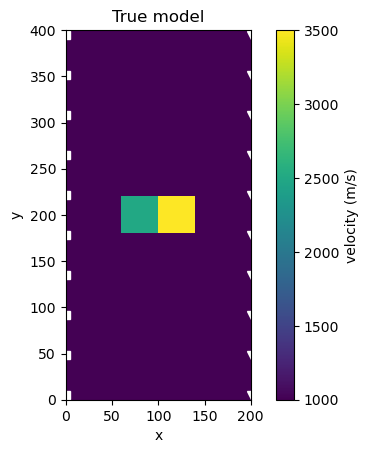

In [120]:
## Making left half of the model block have higher velocity
v0 = 1000
v1 = 2500
v2= 3500
block_x1 = np.r_[60, 100]
block_y = np.r_[180, 220]
block_x2 = np.r_[100,140]
velocity_model = v0*np.ones(mesh.n_cells)
velocity_model = add_block(velocity_model, block_x1, block_y, v1)
velocity_model = add_block(velocity_model, block_x2, block_y, v2)
test_slowness_model = 1/velocity_model
plot_model_survey(
    mesh, velocity_model, source_locations, receiver_locations,
    show_raypaths=False
)

In [121]:
## simulate data
test_simulation = seismic.straight_ray_tomography.Simulation(
    mesh=mesh,
    survey=tomo_survey,
    slownessMap=maps.IdentityMap(mesh),
)
#Predit data
test_clean_data = simulation.dpred(test_slowness_model)

In [122]:

relative_error = 0.02
test_noisy_data = test_clean_data + np.random.randn(len(test_clean_data)) * relative_error * np.abs(test_clean_data)
test_data_object = data.Data(tomo_survey, dobs=test_noisy_data, relative_error=relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=test_data_object, simulation=test_simulation,smallness=True,alpha_y=1e3)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]


SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.30e+08  1.01e+03  0.00e+00  1.01e+03    3.48e+04      0              
   1  6.49e+07  6.70e+02  6.18e-07  7.10e+02    8.91e+04      0              
   2  3.24e+07  6.28e+02  1.08e-06  6.63e+02    1.01e+05      0   Skip BFGS  
   3  1.62e+07  5.80e+02  2.18e-06  6.15e+02    1.06e+05      0   Skip BFGS  
   4  8.11e+06  5.16e+02  5.05e-06  5.57e+02    1.03e+05      0   Skip BFGS  
   5  4.06

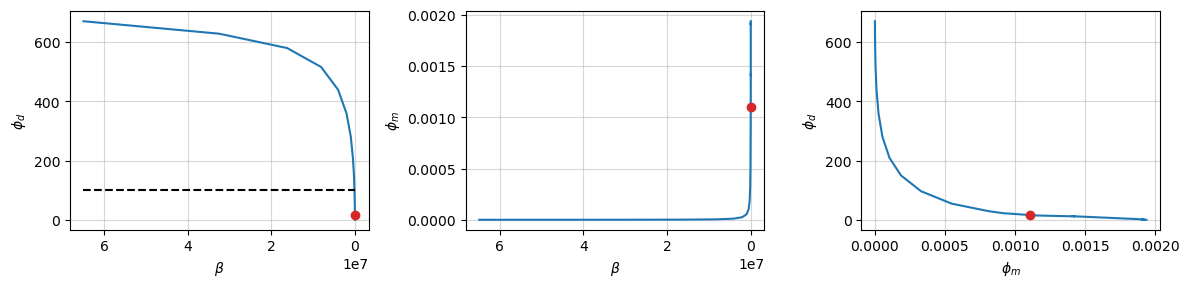

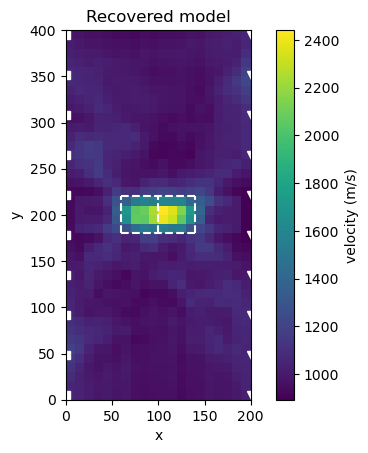

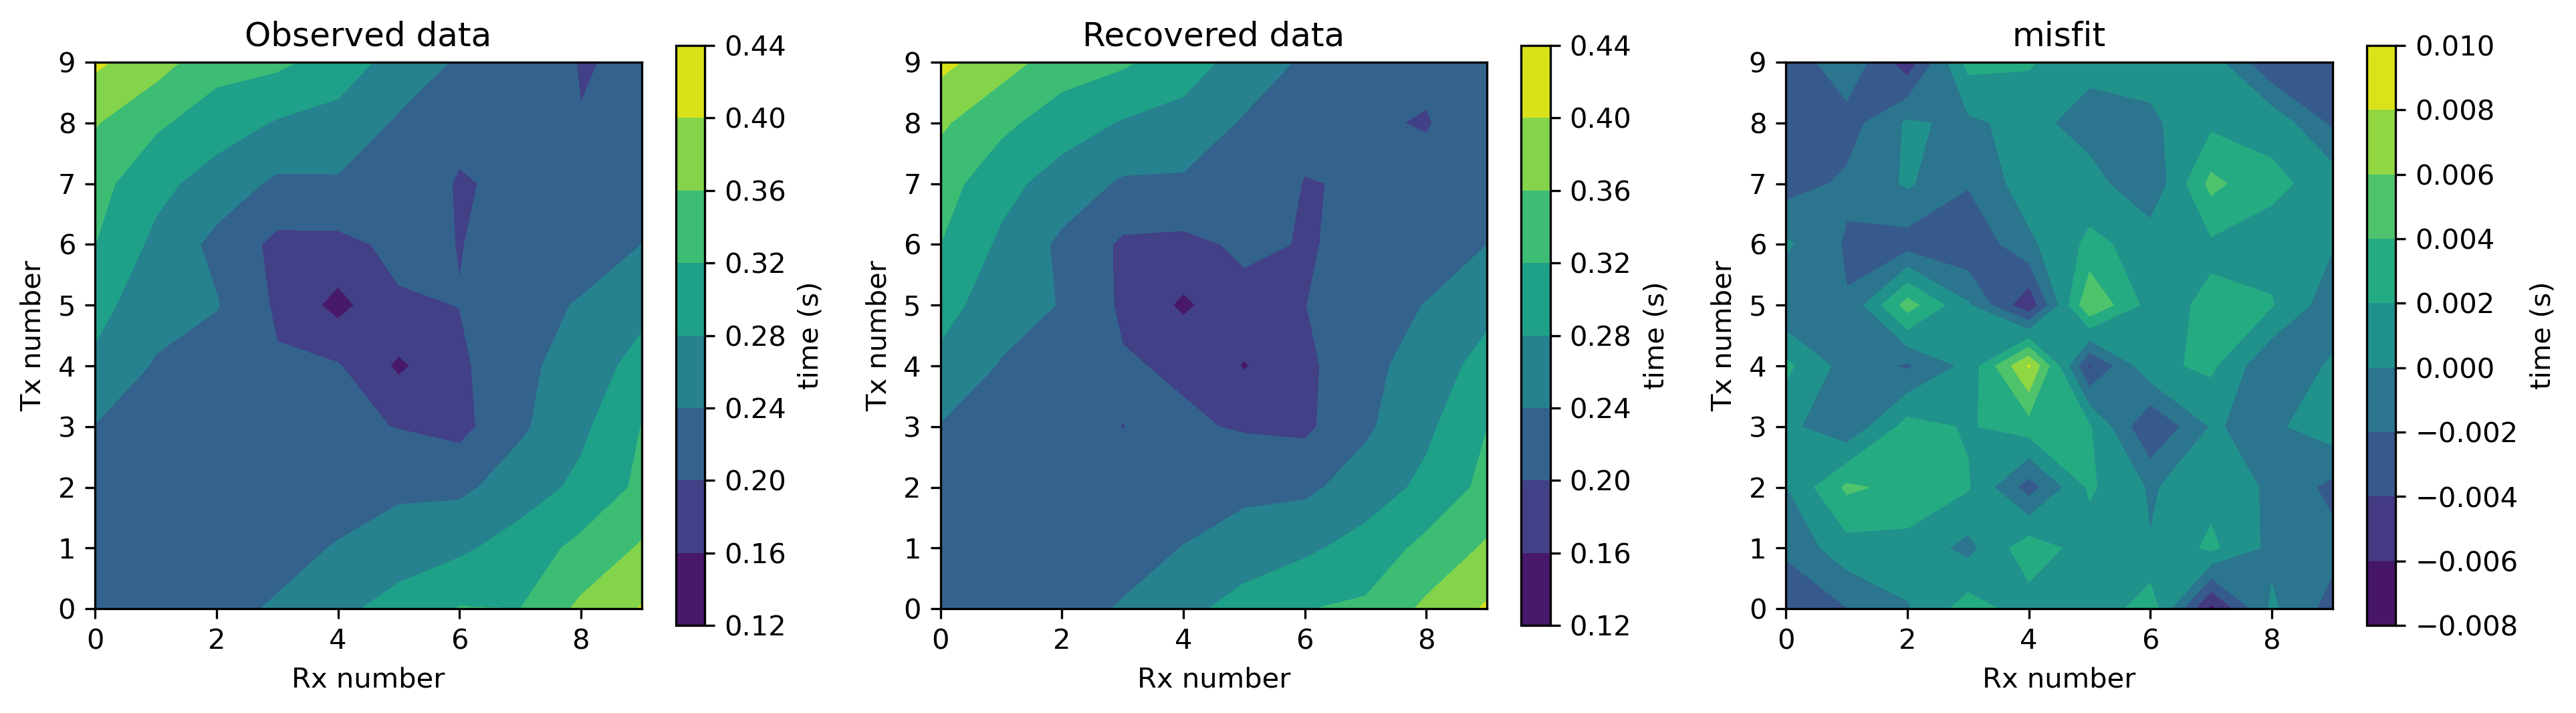

In [123]:
iteration = 14
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(test_noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=False,title="Recovered model"
)
#plot outline of block
# Define the coordinates for the outline of the block
outline_x = np.linspace(block_x1.min(), block_x2.max(), 100)
outline_y_bottom = np.ones_like(outline_x) * block_y.min()
outline_y_top = np.ones_like(outline_x) * block_y.max()

# Plot the outline of the block
plt.plot(outline_x, outline_y_bottom, 'w--')
plt.plot(outline_x, outline_y_top, 'w--')
plt.plot([block_x1.min(), block_x1.min()], [block_y.min(), block_y.max()], 'w--')
plt.plot([block_x1.max(), block_x1.max()], [block_y.min(), block_y.max()], 'w--')
plt.plot([block_x2.max(), block_x2.max()], [block_y.min(), block_y.max()], 'w--')

fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
test_recovered_data = simulation.dpred(models[iteration])
test_difference = test_noisy_data - test_recovered_data
for i, dplot in enumerate([test_noisy_data, test_recovered_data, test_difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i],contour=False)
plt.tight_layout()


SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.26e+08  1.04e+03  0.00e+00  1.04e+03    3.86e+04      0              
   1  6.31e+07  7.53e+02  6.35e-07  7.93e+02    9.05e+04      0              
   2  3.16e+07  6.93e+02  1.33e-06  7.35e+02    1.01e+05      0   Skip BFGS  
   3  1.58e+07  6.30e+02  2.77e-06  6.73e+02    1.06e+05      0   Skip BFGS  
   4  7.89e+06  5.67e+02  5.65e-06  6.11e+02    1.08e+05      0   Skip BFGS  
   5  3.95

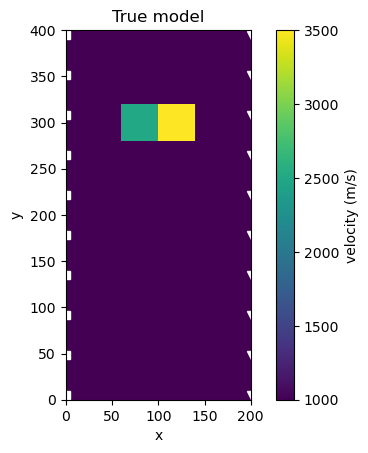

In [126]:
## Making left half of the model block have higher velocity
v0 = 1000
v1 = 2500
v2 = 3500
block_x1 = np.r_[60, 100]
block_y = np.r_[280, 320]
block_x2 = np.r_[100, 140]
velocity_model = v0 * np.ones(mesh.n_cells)
velocity_model = add_block(velocity_model, block_x1, block_y, v1)
velocity_model = add_block(velocity_model, block_x2, block_y, v2)
test_slowness_model = 1 / velocity_model
plot_model_survey(
    mesh, velocity_model, source_locations, receiver_locations,
    show_raypaths=False
)
## simulate data
test_simulation = seismic.straight_ray_tomography.Simulation(
    mesh=mesh,
    survey=tomo_survey,
    slownessMap=maps.IdentityMap(mesh),
)
#Predit data
test_clean_data = simulation.dpred(test_slowness_model)

relative_error = 0.02
test_noisy_data = test_clean_data + np.random.randn(len(test_clean_data)) * relative_error * np.abs(test_clean_data)
test_data_object = data.Data(tomo_survey, dobs=test_noisy_data, relative_error=relative_error)
save, mopt = run_inversion(mesh=mesh, data_object=test_data_object, simulation=test_simulation, smallness=True,
                           alpha_y=1e3)

betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]


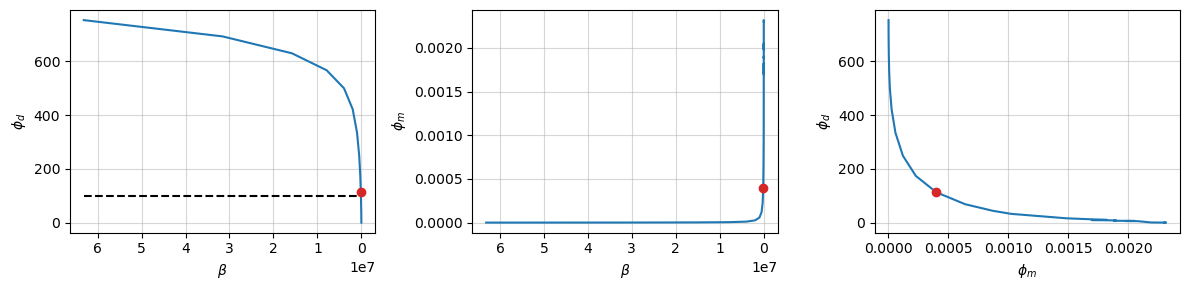

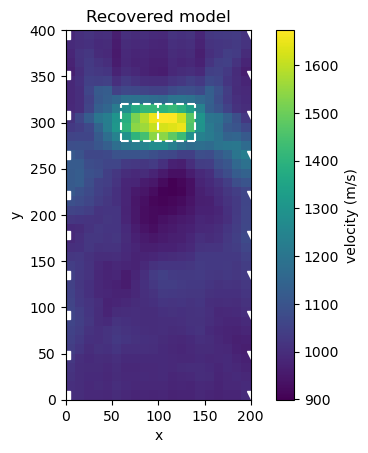

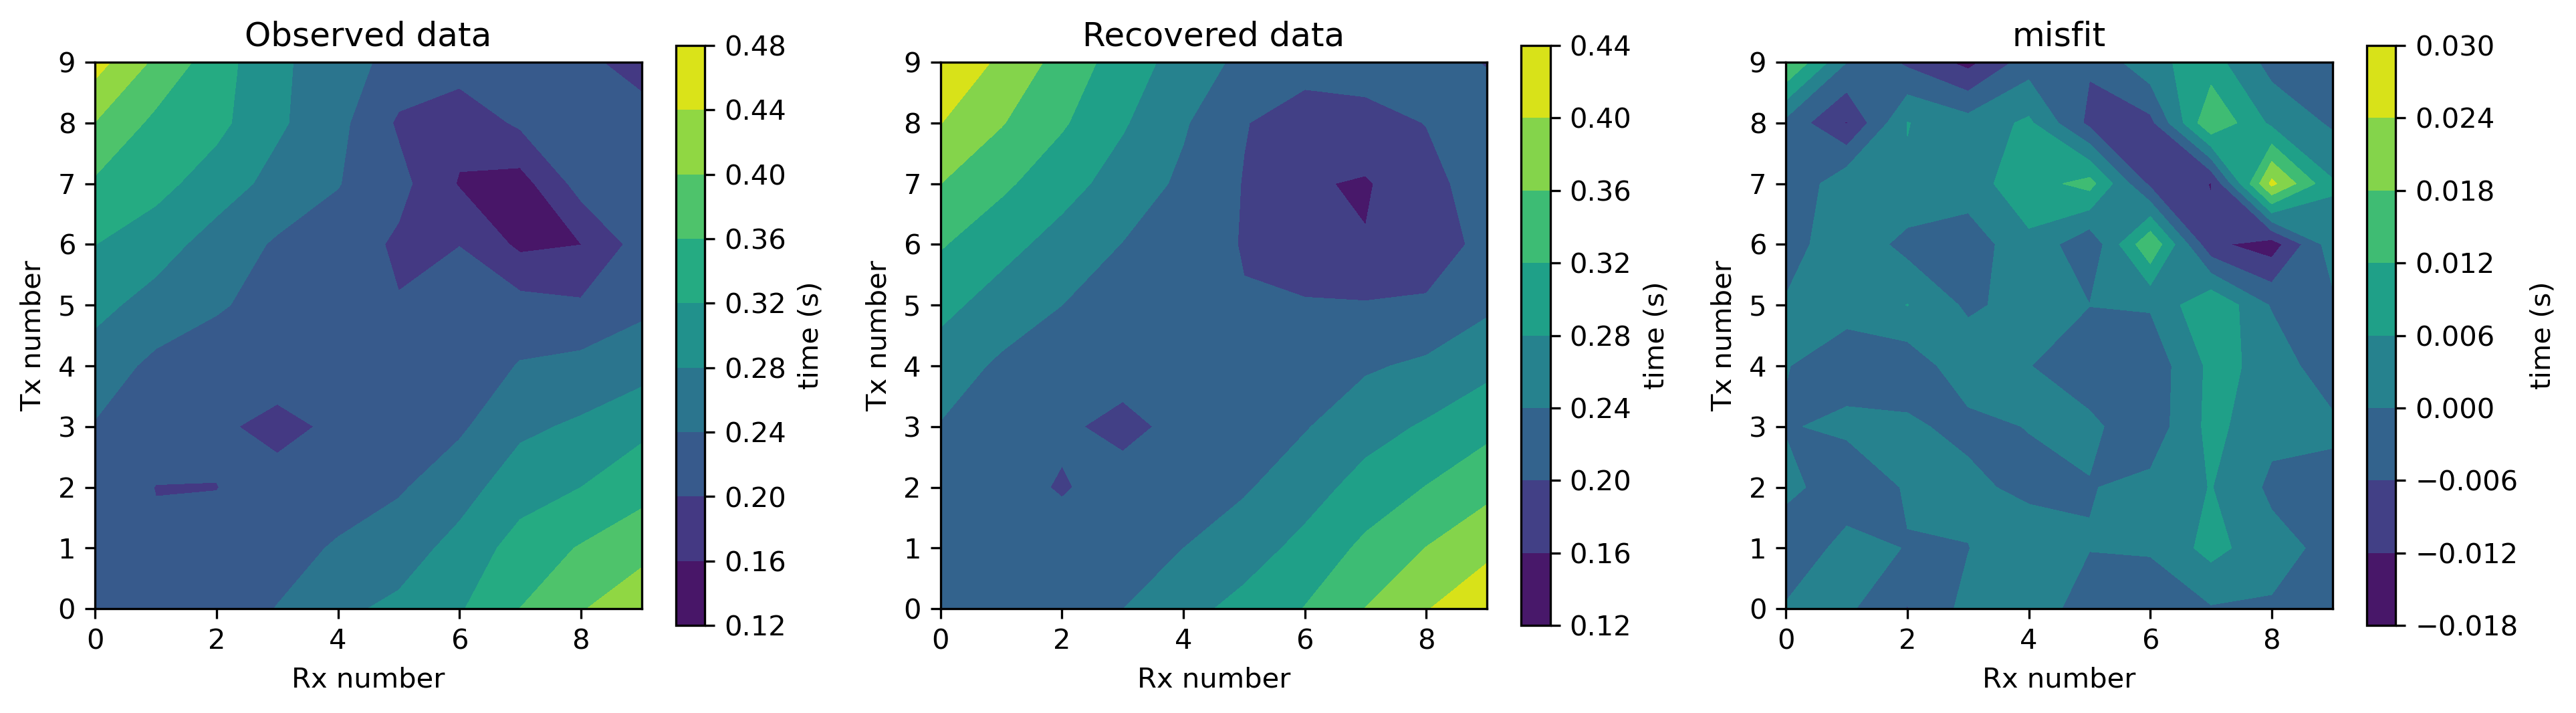

In [129]:

iteration = 9
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(test_noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

plot_model_survey(
    mesh, 1. / models[iteration], source_locations, receiver_locations,
    show_raypaths=False, title="Recovered model"
)
#plot outline of block
# Define the coordinates for the outline of the block
outline_x = np.linspace(block_x1.min(), block_x2.max(), 100)
outline_y_bottom = np.ones_like(outline_x) * block_y.min()
outline_y_top = np.ones_like(outline_x) * block_y.max()

# Plot the outline of the block
plt.plot(outline_x, outline_y_bottom, 'w--')
plt.plot(outline_x, outline_y_top, 'w--')
plt.plot([block_x1.min(), block_x1.min()], [block_y.min(), block_y.max()], 'w--')
plt.plot([block_x1.max(), block_x1.max()], [block_y.min(), block_y.max()], 'w--')
plt.plot([block_x2.max(), block_x2.max()], [block_y.min(), block_y.max()], 'w--')

fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=300)
test_recovered_data = simulation.dpred(models[iteration])
test_difference = test_noisy_data - test_recovered_data
for i, dplot in enumerate([test_noisy_data, test_recovered_data, test_difference]):
    plot_data(ax[i], dplot, ["Observed data", "Recovered data", "misfit"][i], contour=False)
plt.tight_layout()
